Hello!

This notebook presents the solution for the 2021/2022 Open Science Prize using **Qiskit Pulse**. It is ready for execution in Google Colab. Please run the Sections 0-2 to install all necessary packages and define functions. You do not need to run Section 3 to be able to reprocude the solution presented in Section 4.

The best result we were able to achieve on *ibmq_jakarta[1,3,5]* was the fidelity of 0.8666 ± 0.0100, averaged over 12 jobs (8192 shots each).

Best regards,

Alexey Galda

#0 Install (please run, no need to open)

###Packages

In [ ]:
!pip install qiskit

In [ ]:
!pip install imgaug==0.2.5
!pip install sympy==1.3
!pip install folium==0.2.1
!pip install networkx==2.3
!pip install pynauty
!pip install requests==2.23.0

!pip install numpy==1.19.2
!pip install six==1.15.0
!pip install typing-extensions==3.7.4
!pip install coverage==3.7.1

!pip install pylatexenc

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import itertools
from itertools import product
from itertools import permutations
import math
import copy

import seaborn as sns

from matplotlib.cm import ScalarMappable

###Functions

###general functions

In [ ]:
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)

def num_1q_gates(qc):
    dag_circuit = circuit_to_dag(qc)
    gates_all = dag_circuit.count_ops()
    num_1q_pulses = 0
    if 'sx' in gates_all:
        num_1q_pulses += gates_all['sx']
    if 'x' in gates_all:
        num_1q_pulses += gates_all['x']
    num_1q_pulses += 4*6 # adding gates between ZX pulses (inside the custom gates), assuming 4 complete layers
    return num_1q_pulses

def range_diff(r1, r2):
    # useful manupulation with intervals
    s1, e1 = r1
    s2, e2 = r2
    endpoints = sorted((s1, s2, e1, e2))
    result = []
    if endpoints[0] == s1:
        result.append((endpoints[0], endpoints[1]))
    if endpoints[3] == e1:
        result.append((endpoints[2], endpoints[3]))
    return result

def multirange_diff(r1_list, r2_list):
    # useful manupulation with intervals
    for r2 in r2_list:
        r1_list = list(itertools.chain(*[range_diff(r1, r2) for r1 in r1_list]))
    return r1_list

###QPT/tomography/error mitigation functions

In [ ]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

def submit_job(backend, job_id, qobj):
    # submitting QPT job
    if job_id == '':
        job = backend.run(qobj, job_share_level='global')
        target_id = job.job_id()
        print('Run experiment ({})'.format(target_id))
        return 0
    else:
        print('Load experiment result ({})'.format(job_id))
        return backend.retrieve_job(job_id)

def run_qpt(backend,
            qpair,
            calibrated_gate_sched,
            rep_delay,
            shots,
            job_id,
            gate_type,
            theta):
    """Function to run and verify two-qubit QPT
    Args:
        backend: backend
        qpair: target pair of qubits
        calibrated_gate_sched: pulse schedule to perform QPT for
        rep_delay: rep_delay
        shots: shots
        job_id: if an empty string, runs QPT
                if not an empty string, runs QPT and outputs the results (comparing with the target gate_type) instead
        gate_type: 'XX', 'YY', or 'ZZ'
        theta: angle of the 2q rotation
    Return:
        Either a job_id or the QPT result
    """
    if job_id != '':
        calibrated_gate_sched = inst_map.get('id', qubits=(0))
    #
    # QPT fidelity
    #
    calibrated_gate = Gate('gate', num_qubits=2, params=[])
    qregs = QuantumRegister(backend.configuration().n_qubits)
    subspace = [qregs[q] for q in sorted(qpair)]

    tomo_circ = QuantumCircuit(qregs)
    tomo_circ.append(calibrated_gate, qpair)

    qpt_circs = tomo.process_tomography_circuits(
        circuit=tomo_circ,
        measured_qubits=subspace
    )
    for qpt_circ in qpt_circs:
        qpt_circ.add_calibration(calibrated_gate, qpair, calibrated_gate_sched)

    exp_circs, meas_labels = setup_mitigation(backend, qpt_circs, qubits=sorted(qpair))
    exp_scheds = schedule(transpile(exp_circs, backend, optimization_level=0), backend)
    
    qpt_qobj = assemble(exp_scheds,
                        backend=backend,
                        rep_delay=50e-6,
                        shots=shots)
    exp_job = submit_job(backend, job_id, qpt_qobj)
    # job submitted and waiting for execution (0 to avoid hanging)
    if exp_job != 0:
        qpt_result = get_result(exp_job, mem_slots=[0, 1], meas_labels=meas_labels)

        ref_circ = QuantumCircuit(2)

        if gate_type in ['id']:
            ref_oper = qi.Operator(ref_circ)

        #if qpair[0] > qpair[1]:
        if gate_type == 'XX':
            ref_circ.rxx(theta, 0, 1)
            ref_oper = qi.Operator(ref_circ)
        elif gate_type == 'YY':
            ref_circ.ryy(theta, 0, 1)
            ref_oper = qi.Operator(ref_circ)
        elif gate_type == 'ZZ':
            ref_circ.rzz(theta, 0, 1)
            ref_oper = qi.Operator(ref_circ)
        else:
            print("ERROR: operator not supported")

        fitter = tomo.ProcessTomographyFitter(qpt_result, circuits=qpt_circs)
        choi = fitter.fit(method='cvx', solver='CVXOPT')
        pfid = qi.process_fidelity(choi, target=ref_oper, require_cp=False, require_tp=False)

        axis_label = list(map(''.join, product(('I', 'X', 'Y', 'Z'), repeat=2)))
        fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
        plt.xticks(range(len(axis_label)), axis_label, fontsize=9, rotation=90, fontname='Noto Mono')
        plt.yticks(range(len(axis_label)), axis_label, fontsize=9, fontname='Noto Mono')

        # plot reference
        axes[0].imshow(np.real_if_close(qi.PTM(ref_oper).data),
                        interpolation="nearest",
                        cmap="coolwarm",
                        vmin=-1, vmax=1)
        axes[0].set_title(f'Reference {gate_type}({round(theta/np.pi, 2)}$\pi$)')
        axes[0].grid()

        # plot measured channel
        axes[1].imshow(np.real_if_close(qi.PTM(choi).data),
                        interpolation="nearest",
                        cmap="coolwarm",
                        vmin=-1, vmax=1)
        axes[1].set_title('F = {:.3f} {}[{},{}]'.format(pfid, backend.name(),qpair[0],qpair[1]))
        axes[1].grid()

        plt.show()

        print('QPT process fidelity = {:.3e}'.format(pfid))
    else:
        print("job has been submitted")
        pfid = 0
    return pfid

def setup_mitigation(backend, circs, qubits):
    # error mitigation function
    if isinstance(qubits, int):
        qubits = [qubits]

    meas_circs, meas_labels = mit.complete_meas_cal(
        qubit_list=qubits,
        qr=QuantumRegister(backend.configuration().n_qubits),
        circlabel='mcal'
    )
    return meas_circs + circs, meas_labels

def get_result(job, mem_slots, meas_labels, no_mit=False):
    # Returns the results with error mitigation
    result = job.result(timeout=3600)

    if isinstance(mem_slots, int):
        mem_slots = [mem_slots]

    # TO ADD returning result ignoring MIT
    #result = marginal_counts(result, indices=mem_slots)

    exp_result = copy.deepcopy(result)
    exp_result.results = []
    exp_result.results.extend(result.results[len(meas_labels):])
    if no_mit:
        return exp_result
    else:
        # split mitigation experiment
        mit_result = copy.deepcopy(result)
        mit_result.results = []
        mit_result.results.extend(result.results[0:len(meas_labels)])

        # setup fitter
        meas_fitter = mit.CompleteMeasFitter(mit_result, meas_labels,
                                            qubit_list=mem_slots,
                                            circlabel='mcal')
        print('(readout fidelity = {:.3f})'.format(meas_fitter.readout_fidelity()))
        # apply inverse noise matrix to experimental result
        return meas_fitter.filter.apply(exp_result)

###Pulse-specific functions

In [ ]:
def rescale_cr_amp(sched_CR, theta, amp_cr_set, pulse_type, print_details=False):
    """Rescaling function for the default ZX(pi/4) CR pulse to an arbitraty ZX(theta) by changing the amplitude
    Args:
        sched_CR: Pulse schedule of the default CR pulse
        theta: Desired rotation angle
        amp_cr_set: desired pulse amplitude
        pulse_type: 'CRp', returns the ZX(theta/2) pulse
                    'CRm', returns the ZX(-theta/2) pulse
        print_details (bool): If True, prints pulse data
                             If False, doesn't print additional data 
    Return:
        Qiskit schedule: Pulse schedule for ZX pulse
    """
    for inst in sched_CR.instructions:
        # rotary pulse
        if inst[1].channel.prefix == 'd':            
            # sched_CR = CRp
            if inst[1].name[:5] == 'CR90p':
                amp_rot = inst[1].pulse.amp
            # sched_CR = CRm        
            elif inst[1].name[:5] == 'CR90m':
                amp_rot = -inst[1].pulse.amp
            drive_chan = DriveChannel(inst[1].channel.index)
        # crp pulse
        elif inst[1].channel.prefix == 'u':
            duration = inst[1].pulse.duration
            sigma = inst[1].pulse.sigma
            width = inst[1].pulse.width
            n_sigma = (duration - width)/sigma/2
            ctrl_chan = ControlChannel(inst[1].channel.index)   
            # sched_CR = CRp
            if inst[1].name[:5] == 'CR90p':
                amp_crp = inst[1].pulse.amp
            # sched_CR = CRm        
            elif inst[1].name[:5] == 'CR90m':
                amp_crp = -inst[1].pulse.amp
    width_rescaled = 2*theta*width/np.pi + np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/np.sqrt(2))*(2*theta/np.pi - 1)      # my formula
    width_rescaled_16 = get_closest_multiple_of_16(width_rescaled)
    factor = amp_cr_set/np.abs(amp_crp)
    amp_rot = amp_rot * factor
    amp_crp = amp_crp * factor
    dur = round(width_rescaled_16 + 2*n_sigma*sigma)
    sched = Schedule(name=f'CRp[{q_control},{q_target}] (theta={round(theta/np.pi, 3)}$\pi$)')
    if pulse_type in ['CRp', 'crp']:
        sched |= Play(GaussianSquare(duration=dur, amp=amp_rot, width=width_rescaled_16, sigma=sigma, name=f'rot({round(theta/2/np.pi, 3)}$\pi$) [{q_control},{q_target}]'), drive_chan)
        sched |= Play(GaussianSquare(duration=dur, amp=amp_crp, width=width_rescaled_16, sigma=sigma, name=f'CR({round(theta/2/np.pi, 3)}$\pi$) [{q_control},{q_target}]'), ctrl_chan)
    elif pulse_type in ['CRm', 'crm']:
        sched |= Play(GaussianSquare(duration=dur, amp=-amp_rot, width=width_rescaled_16, sigma=sigma, name=f'rot({round(theta/2/np.pi, 3)}$\pi$) [{q_control},{q_target}]'), drive_chan)
        sched |= Play(GaussianSquare(duration=dur, amp=-amp_crp, width=width_rescaled_16, sigma=sigma, name=f'CR({round(theta/2/np.pi, 3)}$\pi$) [{q_control},{q_target}]'), ctrl_chan)
    if print_details:
        print(f"duration = {dur}, width = {width_rescaled_16}, sigma = {sigma}, n_sigma = {n_sigma}, abs(amp_crp) = {np.abs(amp_crp)}, abs(amp_rot) = {np.abs(amp_rot)}\n")
    return sched

def extract_X_pulse_parameters_for_qubits(backend_config, inst_map):
    # extract X pulse parameters for each qubit
    n_qubits = backend_config.to_dict()['n_qubits']
    for qubit in range(n_qubits):
        sched_x = inst_map.get('x', qubits=qubit)
        x_dur = sched_x.instructions[0][1].pulse.duration
        x_sigma = sched_x.instructions[0][1].pulse.sigma
        x_amp = sched_x.instructions[0][1].pulse.amp
        x_beta = sched_x.instructions[0][1].pulse.beta
        x_sched = Schedule()
        y_sched = Schedule()
        x_sched |= Play(Drag(duration=x_dur, amp=1j*x_amp, sigma=x_sigma, beta=x_beta), DriveChannel(qubit))
        y_sched |= Play(Drag(duration=x_dur, amp=x_amp, sigma=x_sigma, beta=x_beta), DriveChannel(qubit))
        if inst_map.has('Xp', qubits=(qubit, )):
            inst_map.remove('Xp', qubits=(qubit, ))
        inst_map.add('Xp', qubits=(qubit, ), schedule=x_sched)
        if inst_map.has('Yp', qubits=(qubit, )):
            inst_map.remove('Yp', qubits=(qubit, ))
        inst_map.add('Yp', qubits=(qubit, ), schedule=y_sched)
    return inst_map

def sched_xy4(n_rep, qubit, inst_map):
    # creates a pulse schedule for XY4 identities
    sched_xy4 = Schedule()
    for i in range(n_rep):
        sched_xy4 += inst_map.get('Xp', qubit)
        sched_xy4 += inst_map.get('Yp', qubit)
        sched_xy4 += inst_map.get('Xp', qubit)
        sched_xy4 += inst_map.get('Yp', qubit)
    return sched_xy4

def schedule_to_circuit(schedule, nqubits, active_qubits, label='qaoa'):
    """Converts schedule to a circuit with one gate wrapping the schedule
    nqubits is total number of qubits in circuit
    active_qubits (list) is the list of qubit indices on which the schedule is acting
    """
    assert(isinstance(active_qubits, list))
    qc = QuantumCircuit(nqubits)

    qc.append(Gate(label, len(active_qubits), []), active_qubits)
    qc.add_calibration(label, qubits=active_qubits, schedule=schedule)
    qc.name = schedule.name
    return qc

def add_DD(sched, qq, backend_config, inst_map, mode=1):
    """Creates a pulse schedule by adding DD sequences to the input schedule
    Args:
        sched: input schedule
        qq (list): list of qubits for adding DD
        backend_config: backend_config
        inst_map : inst_map
    Return:
        Qiskit schedule: Pulse schedule with added DD sequences
    """
    # qq is a list of physical qubits for which DD is to be added (q_reg)
    sched_DD = sched
    if mode > 0:
        for qubit in qq:
            drive_chan = DriveChannel(qubit)
            sched_drive = sched.filter(channels=(drive_chan))
            if sched_drive.duration > 0:
                if sched.filter(channels=(MeasureChannel(qubit))).duration > 0: #
                    meas_chan = MeasureChannel(qubit)                      #
                    meas_int = sched.filter(channels=(meas_chan))           #
                    meas_start = meas_int.instructions[0][0]               #
                    #print(f"meas_start = {meas_start}\nsched.duration = {sched.duration}") #
                else:                                                      #
                    meas_start = sched.duration                            #
                #total_int = [(sched_drive.instructions[0][0], sched.duration)]
                total_int = [(sched_drive.instructions[0][0], meas_start)] #
                drive_int = sched_drive.timeslots[drive_chan]
                total_int = multirange_diff(total_int, drive_int)
                total_int = [item for item in total_int if item[0] < item[1]]

                ctrl_channels_all = [backend.configuration().control(qpair)[0] for qpair in backend_config.to_dict()['coupling_map'] if qubit in qpair]
                ctrl_channels_used = [item for item in ctrl_channels_all if item in sched.channels]
                for ctrl_chan in ctrl_channels_used:
                    ctrl_int = sched.filter(channels=(ctrl_chan)).timeslots[ctrl_chan]
                    total_int = multirange_diff(total_int, ctrl_int)
                    total_int = [item for item in total_int if item[0] < item[1]]

                total_int = [item for item in total_int if item[1] - item[0] > 4*160]
                total_rep = [(item[1] - item[0]) // (160*4) for item in total_int]

                for interval in total_int:
                    n = int((interval[1] - interval[0]) // (160*4))
                    sched_DD = sched_DD.insert(int(interval[0] + (interval[1] - interval[0] - n*160*4)/2), sched_xy4(n, qubit, inst_map))
            else:
                print(f"DriveChannel{qubit} not found!")
    return sched_DD

def cr_from_cx(q0, q1, gate):
    """Extracts CR pulse from the default CNOT gate
    Args:
        q0: control qubit
        q1: target qubit
        gate: 'CRp' or 'CRm', ZX(pi/4) or ZX(-pi/4)
    Return:
        Qiskit schedule: Pulse schedule for the CR pulse
    """
    num_qubits = backend.configuration().n_qubits
    # pick the order of indices (q0, q1) that corresponds to the shorter CNOT[q0, q1]
    dur_0 = inst_map.get('cx', (q0, q1)).duration
    dur_1 = inst_map.get('cx', (q1, q0)).duration
    if dur_0 > dur_1:
        q0, q1 = q1, q0

    # determine CR pulse duration
    CNOT = inst_map.get('cx', (q0, q1))
    for i in range(len(CNOT.instructions)):
        if type(CNOT.instructions[i][1]) == pulse.instructions.play.Play and str(CNOT.instructions[i][1].channel)[0:7] == "Control":
            cr_dur = CNOT.instructions[i][1].pulse.duration
            break
        if type(CNOT.instructions[i][1]) == pulse.instructions.play.Play and str(CNOT.instructions[i][1].channel)[0:5] == "Drive":
            drive_chan_rotary = CNOT.instructions[i][1].channel.index

    # disassemble CNOT
    qc = QuantumCircuit(2)
    qc.cx(0, 1)
    qc_transpiled = transpile(qc, backend, initial_layout=[q0, q1])
    sched = schedule(qc_transpiled, backend)

    u_dur = 160 # 1q pulse duration
    # identify CR_p and CR_m pulses
    sched_crp = Schedule(name="CRp")
    sched_crp |= sched.filter(time_ranges=[(u_dur, u_dur + cr_dur)])
    sched_crp = sched_crp.shift(-u_dur)
    
    sched_crm = Schedule(name="CRm")
    sched_crm |= sched.filter(time_ranges=[(u_dur*2 + cr_dur, u_dur*2 + 2*cr_dur)])
    sched_crm = sched_crm.shift(-u_dur*2-cr_dur)
    
    crp_gate = Gate('CRp_gate', 2, [])
    crm_gate = Gate('CRm_gate', 2, [])
    
    circ = QuantumCircuit(num_qubits)
    if gate=='CRp':
        circ.append(crp_gate, (q0, q1))
        circ.add_calibration(crp_gate, (q0, q1), sched_crp)

        sched = Schedule(name=f"CRp[{q0}, {q1}]")
        sched |= schedule(transpile(circ, backend), backend)
    elif gate =='CRm':
        circ.append(crm_gate, (q0, q1))
        circ.add_calibration(crm_gate, (q0, q1), sched_crm)

        sched = Schedule(name=f"CRm[{q0}, {q1}]")
        sched |= schedule(transpile(circ, backend), backend)
    else:
        print("ERROR: gate not specified")

    return sched
        
def basis_from_letter(letter, qq):
    # converts the single-letter notations to 2q gates on the list of 3 qubits qq.
    if letter == 'X':
        basis = 'XX'
        qpair = (qq[0], qq[1])
    elif letter == 'x':
        basis = 'XX'
        qpair = (qq[1], qq[2])
    elif letter == 'Y':
        basis = 'YY'
        qpair = (qq[0], qq[1])
    elif letter == 'y':
        basis = 'YY'
        qpair = (qq[1], qq[2])
    elif letter == 'Z':
        basis = 'ZZ'
        qpair = (qq[0], qq[1])
    elif letter == 'z':
        basis = 'ZZ'
        qpair = (qq[1], qq[2])
    else:
        print("ERROR: wrong letter")
    return basis, qpair

def shift_last_pulse(circ_sched, qubit):
    # collect all channels connected to the qubit
    cnots = backend_config.to_dict()['coupling_map']
    u_chans = []
    for i in range(0, len(backend.properties().to_dict()['gates'])):
        if backend.properties().to_dict()['gates'][i]['gate'] == 'cx':
            qubits = backend.properties().to_dict()['gates'][i]['qubits']
            u_chan = cnots.index(backend.properties().to_dict()['gates'][i]['qubits'])
            if qubit in qubits:
                u_chans.append(u_chan)

    # isolate the pulse to be shifted
    drive_chan = DriveChannel(qubit)
    sched_drive = circ_sched.filter(channels=(drive_chan))

    pulse_stop = sched_drive.ch_stop_time(drive_chan)
    pulse_start = pulse_stop - 160

    sched_pulse = sched_drive.filter(intervals=[(pulse_start, pulse_stop)])
    sched_pulse = sched_pulse.shift(-pulse_start)
    
    # insert into the rest of the schedule at time pulse_new_start
    sched_rest = circ_sched.exclude(channels=[drive_chan] + [ControlChannel(u_chan) for u_chan in u_chans], intervals=[(pulse_start, pulse_stop)])
    pulse_new_start = 0
    for chan in [DriveChannel(qubit)] + [ControlChannel(u_chan) for u_chan in u_chans]:
        end_time = sched_rest.ch_stop_time(chan)
        if end_time > pulse_new_start:
            pulse_new_start = end_time

    sched_new = sched_rest.insert(pulse_new_start, sched_pulse)
    return sched_new

def rescale_cr(sched_CR, theta, pulse_type, adjust_amp=False, nate=False, zero_pulse=False, print_details=False):
    """Rescale the default ZX(pi/4) CR pulse to an arbitraty ZX(theta)
    Args:
        sched_CR: Pulse schedule of the default CR pulse
        theta: Desired rotation angle
        pulse_type: 'CRp', returns the ZX(theta/2) pulse
                    'CRm', returns the ZX(-theta/2) pulse
        adjust_amp (bool): If True, adjusts the amplitude to exactly match the area under the pulse
                                    to the desired one (cannot be achieved exactly dute to discrete pulse durations)
                           If False, keep the original amplitude of the CR and rotary pulses
        nate (bool): If True, uses the slightly different (by <1%) rescaling of the pulses, based on
                              https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043088 (error suspected)
                     If False, use Alexey's rescaling function
        print_details (bool): If True, prints pulse data
                             If False, doesn't print additional data 
    Return:
        Qiskit schedule: Pulse schedule for ZX pulse
    """
    for inst in sched_CR.instructions:
        # rotary pulse
        if inst[1].channel.prefix == 'd':            
            # sched_CR = CRp
            if inst[1].name[:5] == 'CR90p':
                amp_rot = inst[1].pulse.amp
            # sched_CR = CRm        
            elif inst[1].name[:5] == 'CR90m':
                amp_rot = -inst[1].pulse.amp
            drive_chan_index = inst[1].channel.index
            drive_chan = DriveChannel(drive_chan_index)
        # crp pulse
        elif inst[1].channel.prefix == 'u':
            duration = inst[1].pulse.duration
            sigma = inst[1].pulse.sigma
            width = inst[1].pulse.width
            n_sigma = (duration - width)/sigma/2
            ctrl_chan = ControlChannel(inst[1].channel.index)   
            # sched_CR = CRp
            if inst[1].name[:5] == 'CR90p':
                amp_crp = inst[1].pulse.amp
            # sched_CR = CRm        
            elif inst[1].name[:5] == 'CR90m':
                amp_crp = -inst[1].pulse.amp
    if theta > 0:
        if nate == False:
          width_rescaled = 2*theta*width/np.pi + np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/np.sqrt(2))*(2*theta/np.pi - 1)      # my formula
        else:
          width_rescaled = 2*theta*width/np.pi + np.sqrt(2*np.pi)*sigma*math.erf(n_sigma)*(2*theta/np.pi - 1)                # Nate without sqrt(2)
        width_rescaled_16 = get_closest_multiple_of_16(width_rescaled)
        #if print_details:
        #    print(f"theta > 0 ({theta}), width_rescaled_16 = {width_rescaled_16}")
        # default CR pulse amplitude is sufficient toimplement the ZX(theta) gate by rescaling the width of the GaussianSquare pulses
        if width_rescaled_16 >= 0:
            if adjust_amp:
                # delta in area (rescaled - needed) because of get_closest_multiple_of_16
                if nate == False:
                  area_needed = np.abs(amp_crp)*(width_rescaled + np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/np.sqrt(2)))            # my formula
                  area_rescaled = np.abs(amp_crp)*(width_rescaled_16 + np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/np.sqrt(2)))       # my formula
                else:
                  area_needed = np.abs(amp_crp)*(width_rescaled + np.sqrt(2*np.pi)*sigma*math.erf(n_sigma))                      # Nate without sqrt(2)
                  area_rescaled = np.abs(amp_crp)*(width_rescaled_16 + np.sqrt(2*np.pi)*sigma*math.erf(n_sigma))                 # Nate without sqrt(2)
                amp_rot = amp_rot * area_needed/area_rescaled
                amp_crp = amp_crp * area_needed/area_rescaled
            dur = round(width_rescaled_16 + 2*n_sigma*sigma)
            sched = Schedule(name=f'CR (theta={round(theta/np.pi, 3)}$\pi$)')
            if pulse_type in ['CRp', 'crp']:
                sched |= Play(GaussianSquare(duration=dur, amp=amp_rot, width=width_rescaled_16, sigma=sigma, name=f'rot({round(theta/2/np.pi, 3)}$\pi$)'), drive_chan)
                sched |= Play(GaussianSquare(duration=dur, amp=amp_crp, width=width_rescaled_16, sigma=sigma, name=f'ZX({round(theta/2/np.pi, 3)}$\pi$)'), ctrl_chan)
            elif pulse_type in ['CRm', 'crm']:
                sched |= Play(GaussianSquare(duration=dur, amp=-amp_rot, width=width_rescaled_16, sigma=sigma, name=f'rot(-{round(theta/2/np.pi, 3)}$\pi$)'), drive_chan)
                sched |= Play(GaussianSquare(duration=dur, amp=-amp_crp, width=width_rescaled_16, sigma=sigma, name=f'ZX(-{round(theta/2/np.pi, 3)}$\pi$)'), ctrl_chan)
        # default CR pulse amplitude is too large to implement the small-angle ZX gate, must rescale the amplitude
        # area of a small Gaussian pulse: alpha(theta) = |amp(theta)|*sqrt(2*pi)*sigma*erf(n_sigma/sqrt(2))
        # area of the default calibrated GaussianSquare pulse (theta = pi/2): alpha_cal = |amp_cal|*[width + sqrt(2*pi)*sigma*erf(n_sigma/sqrt(2))]
        # to find the amplitude of a small Gaussian pulse corresponding to the rotation by theta, we solve this equation:
        # theta/(pi/2) = alpha(theta)/alpha_cal, which gives:
        # amp(theta) = factor*amp_cal = 2*theta/np.pi*(1 + width/(np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/np.sqrt(2))))
        # this assumed the duration of the pulse of 2*n_sigma*sigma. Default n_sigma = 2.
        else:
            width_rescaled_16 = 0
            #factor = 2*theta/np.pi*np.abs(amp_crp)*(width/(np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/np.sqrt(2))) + 1)/amp_crp
            factor = 2*theta/np.pi*(1 + width/(np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/np.sqrt(2))))
            amp_crp_rescaled = factor*amp_crp
            amp_rot_rescaled = factor*amp_rot
            dur = round(2*n_sigma*sigma)
            # let's reduce the total pulse duration from 4*sigma to 2*sigma if rescaled CR amplitude is < 0.3:
            if abs(amp_crp_rescaled) < 0.3:
                factor = 2*theta/np.pi*(1 + width/(np.sqrt(2*np.pi)*sigma*math.erf(n_sigma/2/np.sqrt(2)))) # divided n_sigma by 2
                amp_crp_rescaled = factor*amp_crp
                amp_rot_rescaled = factor*amp_rot
                dur = round(n_sigma*sigma) # divided n_sigma by 2
                if print_details:
                    print(f" duration = {dur} (n_sigma = 1), abs(amp_crp) = {round(np.abs(amp_crp),3)}, abs(amp_crp_rescaled) = {round(np.abs(amp_crp_rescaled), 3)}, factor = {round(factor, 3)}")
            elif print_details:
                print(f" duration = {dur} (n_sigma = 2), abs(amp_crp) = {round(np.abs(amp_crp),3)}, abs(amp_crp_rescaled) = {round(np.abs(amp_crp_rescaled), 3)}, factor = {round(factor, 3)}")  
            sched = Schedule(name=f'CR (theta={round(theta/np.pi, 3)}$\pi$)')
            if pulse_type in ['CRp', 'crp']:
                sched |= Play(GaussianSquare(duration=dur, amp=amp_rot_rescaled, width=width_rescaled_16, sigma=sigma, name=f'rot({round(theta/2/np.pi, 3)}$\pi$)'), drive_chan)
                sched |= Play(GaussianSquare(duration=dur, amp=amp_crp_rescaled, width=width_rescaled_16, sigma=sigma, name=f'ZX({round(theta/2/np.pi, 3)}$\pi$)'), ctrl_chan)
            elif pulse_type in ['CRm', 'crm']:
                sched |= Play(GaussianSquare(duration=dur, amp=-amp_rot_rescaled, width=width_rescaled_16, sigma=sigma, name=f'rot(-{round(theta/2/np.pi, 3)}$\pi$)'), drive_chan)
                sched |= Play(GaussianSquare(duration=dur, amp=-amp_crp_rescaled, width=width_rescaled_16, sigma=sigma, name=f'ZX(-{round(theta/2/np.pi, 3)}$\pi$)'), ctrl_chan)
            amp_rot = amp_rot_rescaled
            amp_crp = amp_crp_rescaled
    else:
        if zero_pulse:
          dur = 0
          width_rescaled_16 = 0
          sched = Schedule(name=f'CR_zero (theta=0)')
          sched |= Play(Constant(duration=64, amp=0.0), drive_chan)
          sched |= Play(Constant(duration=64, amp=0.0), ctrl_chan)
        else:
          dur = 0
          width_rescaled_16 = 0
          sched = Schedule(name=f'CR (theta=0)')
        if print_details:
            print(f"theta = 0 ({theta}), width_rescaled_16 = {width_rescaled_16}")
    if print_details:
        print(f" duration = {dur}, width = {width_rescaled_16}, sigma = {sigma}, n_sigma = {n_sigma}, abs(amp_crp) = {round(np.abs(amp_crp), 3)}, abs(amp_rot) = {round(np.abs(amp_rot), 3)}\n")
    return sched

def schedule_base_2q(base_gates, theta, qpair, zero_pulse=False, amp_cr_set=None, print_details=False):
    """Creates a pulse schedule for given 'base_gates' consisting of 1q gates sandwitched between ZX(theta) and ZX(-theta)
    Args:
        base_gates: 'X_id','Y_id','id_X', 'id_Y', or 'X_X', corresponding to the two 1q gates between the ZX's
        theta: Desired rotation angle
        qpair: Qubit pair for which the schedule is created
        amp_cr_set: magnitude of the desired amplitude on the ZX pulses
    Return:
        Qiskit schedule: Pulse schedule for the 'base' of the XX, YY, and ZZ gates
    """
    q_control, q_target = qpair

    adjust_amp = True
    sched_CR = cr_from_cx(q_control, q_target, "CRp")
    if amp_cr_set and theta > 0:
        sched_crp = rescale_cr_amp(sched_CR, theta, amp_cr_set, 'CRp', print_details=print_details)
        sched_crm = rescale_cr_amp(sched_CR, theta, amp_cr_set, 'CRm', print_details=print_details)
    else:
        sched_crp = rescale_cr(sched_CR, theta, 'CRp', zero_pulse=zero_pulse, adjust_amp=adjust_amp, print_details=print_details)
        sched_crm = rescale_cr(sched_CR, theta, 'CRm', zero_pulse=zero_pulse, adjust_amp=adjust_amp, print_details=print_details)

    # X_id
    sched_base = Schedule(name=f'base[{q_control},{q_target}]')
    sched_base |= sched_crp                                                                                     # CRp
    sched_base |= inst_map.get('x', qubits=(q_control)) << sched_base.duration                                  # X_control
    sched_base |= sched_crm << sched_base.duration                                                              # CRm
    sched_base_X_id = sched_base

    # Y_id
    sched_base = Schedule(name=f'base[{q_control},{q_target}]')
    sched_base |= sched_crp                                                                                     # CRp
    sched_base |= inst_map.get('u1', P0=-np.pi/2, qubits=(q_control)) << sched_base.duration                    # Z(-pi/2)_control
    sched_base |= inst_map.get('x', qubits=(q_control)) << sched_base.duration                                  # X_control
    sched_base |= inst_map.get('u1', P0=np.pi/2, qubits=(q_control)) << sched_base.duration                     # Z(pi/2)_control
    sched_base |= sched_crm << sched_base.duration                                                              # CRm
    sched_base_Y_id = sched_base

    # id_X
    sched_base = Schedule(name=f'base[{q_control},{q_target}]')
    sched_base |= sched_crp                                                                                     # CRp
    sched_base |= inst_map.get('x', qubits=(q_target)) << sched_base.duration                                   # X_target
    sched_base |= sched_crm << sched_base.duration                                                              # CRm
    sched_base_id_X = sched_base

    # id_Y
    sched_base = Schedule(name=f'base[{q_control},{q_target}]')
    sched_base |= sched_crp                                                                                     # CRp
    sched_base |= inst_map.get('u1', P0=-np.pi/2, qubits=(q_target)) << sched_base.duration                     # Z(-pi/2)_target
    sched_base |= inst_map.get('x', qubits=(q_target)) << sched_base.duration                                   # X_target
    sched_base |= inst_map.get('u1', P0=np.pi/2, qubits=(q_target)) << sched_base.duration                      # Z(pi/2)_target
    sched_base |= sched_crm << sched_base.duration                                                              # CRm
    sched_base_id_Y = sched_base

    # X_X
    sched_base = Schedule(name=f'base[{q_control},{q_target}]')
    sched_base |= sched_crp                                                                                     # CRp
    sched_dur = sched_base.duration
    sched_base |= inst_map.get('x', qubits=(q_control)) << sched_base.duration                                  # X_control
    sched_base |= inst_map.get('x', qubits=(q_target)) << sched_dur                                             # X_target
    sched_base |= sched_crm << sched_base.duration                                                              # CRm
    sched_base_X_X = sched_base

    if base_gates=='X_id':
        return sched_base_X_id
    elif base_gates=='Y_id':
        return sched_base_Y_id
    elif base_gates=='id_X':
        return sched_base_id_X
    elif base_gates=='id_Y':
        return sched_base_id_Y
    elif base_gates=='X_X':
        return sched_base_X_X
    else:
        print("ERROR: 2q base_gates must be 'X_id','Y_id','id_X', 'id_Y', 'X_X'.")

def qc_Trot(seq, theta_list, qq, optimization_level=1, versions=[1]*6, zero_layers=0, shifted=False, zero_pulse=False, print_details=False, amp_cr_set_list=False):
    """Creates a circuit for the Trotterized evolution. Can only currently work with theta_list that consists of
    no more than 2 different theta values (sufficient for the challenge).
    Args:
        seq: shorthand notations for the repeated order of XX, YY, and ZZ gates, e.g. 'XyYzZY'.
             The same order is repeated for all layers.
        theta_list: list of rotation angles theta for XX(theta), YY(theta), ZZ(theta) within each layer.
                    Note that if a layer evolves the system by t = pi/2, then the angle should be double that: theta = pi.
        shifted (bool): If True, a small feature to shift the last pulse played on Q1 to the earliest possible moment
                                 (transpiler tends to move it later, creating an annecessary gap)
                        If False, no such pulse modification
        zero_pulse (bool): If True, adds a 64-sample zero-amplitu pulse when theta=0 (for debugging)
        print_details: whether to print additional details about the Trotterization circuit (for testing)
        amp_cr_set_list (list): optional list of custom fixed amplitude for the ZX[1,3] and ZX[3,5] pulses (for testing/calibration)
    Return:
        Quantum circuit for the entire Trotterized evolution experiment
    """
    

    num_qubits = backend.configuration().n_qubits
    qr = QuantumRegister(num_qubits)
    qc_Trot = QuantumCircuit(qr, name=f"Trotter [{round(theta_list[0]/2/np.pi, 2)}, {round(theta_list[1]/2/np.pi, 2)}, {round(theta_list[2]/2/np.pi, 2)}, {round(theta_list[3]/2/np.pi, 2)}]*$\pi$")

    qc_Trot.x([qr[qq[1]], qr[qq[2]]])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    theta_list = list(theta_list)

    if np.abs(np.sum(theta_list) - 2*np.pi) > 0.0001:
        print("ERROR: theta_list must add up to 2*pi")

    if versions != [1]*6:
        print("CAUTION: are you debugging the code? versions=[1]*6 by default, and must have a length multiple of 6.")

    if len(seq)%6 == 0:
        if len(versions) > 6:
            print("WARNING: only specify the first 6 versions of XX,YY,ZZ gates for Trotterization, they will be the same in all layers.")

    if len(np.unique(theta_list)) > 2:
        print(f"ERROR: this function does not currently support more than two different values in theta_list.")
    seq_total = seq*len(theta_list)
    if print_details:
        print(f"theta_list = {theta_list}\nseq_total = {seq_total}")
    base_gate_name_list = []
    for i, letter in enumerate(list(seq_total)):
        version = versions[i%6]
        basis, qpair = basis_from_letter(letter, qq)

        ### determine if the the qpair is ordered in the CX_forward direction
        dur_0 = inst_map.get('cx', qpair).duration
        dur_1 = inst_map.get('cx', qpair[::-1]).duration
        if dur_0 < dur_1:
            qpair_forward = qpair
            q0, q1 = 0,1
        else:
            qpair_forward = qpair[::-1]
            q0, q1 = 1,0

        theta = theta_list[i//6]

        # mark layers with theta = 0, to assign a different gate name to the corresponding 2q gates for correct transpilation.
        if theta == np.max(theta_list):
            basis = basis
        elif theta == np.min(theta_list):
            basis = basis + '0'
        if print_details:
            print(f"i = {i}, letter = {letter}, basis = {basis}, theta = {theta}")      
            
        base_gate_name = f'{basis}{version}_base[{qpair_forward[0]},{qpair_forward[1]}]'
        base_name = f'{basis}{version}[{qpair_forward[0]},{qpair_forward[1]}]'
        # set custom amplitudes if specified (if trying CR amplitudes different from the calibrated ones/for testing)
        if amp_cr_set_list:
            if 1 in qpair:
                amp_cr_set = amp_cr_set_list[0]
            elif 5 in qpair:
                amp_cr_set = amp_cr_set_list[1]
            else:
                print("ERROR: something's wrong with qubit labels in qc_Trot()")
        else:
            amp_cr_set = False
        if basis=='XX':
            if version==1:
                sched_base_XX1 = schedule_base_2q('Y_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_XX1 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(-np.pi/2, q0)
                qc.append(base_gate_XX1, [q0, q1])
                qc.ry(-np.pi/2, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_XX1, qpair_forward, sched_base_XX1)
            elif version==2:
                sched_base_XX2 = schedule_base_2q('Y_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_XX2 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(np.pi/2, q0)
                qc.rz(np.pi, q1)
                qc.append(base_gate_XX2, [q0, q1])
                qc.rz(np.pi, q1)
                qc.ry(np.pi/2, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_XX2, qpair_forward, sched_base_XX2)
        elif basis=='YY':
            if version==1:
                sched_base_YY1 = schedule_base_2q('X_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_YY1 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.sx(q0)
                qc.rz(-np.pi/2, q1)
                qc.append(base_gate_YY1, [q0, q1])
                qc.rz(np.pi/2, q1)
                qc.sx(q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_YY1, qpair_forward, sched_base_YY1)
            elif version==2:
                sched_base_YY2 = schedule_base_2q('X_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_YY2 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.rx(-np.pi/2, q0)
                qc.rz(np.pi/2, q1)
                qc.append(base_gate_YY2, [q0, q1])
                qc.rz(-np.pi/2, q1)
                qc.rx(-np.pi/2, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_YY2, qpair_forward, sched_base_YY2)
        elif basis=='ZZ':
            if version==1:
                sched_base_ZZ1 = schedule_base_2q('X_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_ZZ1 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(np.pi/2, q1)
                qc.append(base_gate_ZZ1, [q0, q1])
                qc.ry(-np.pi/2, q1)
                qc.rx(np.pi, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_ZZ1, qpair_forward, sched_base_ZZ1)
            if version==2:
                sched_base_ZZ2 = schedule_base_2q('Y_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_ZZ2 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(np.pi/2, q1)
                qc.append(base_gate_ZZ2, [q0, q1])
                qc.ry(-np.pi/2, q1)
                qc.ry(np.pi, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_ZZ2, qpair_forward, sched_base_ZZ2)
        # custom gates for zero_layers (must be different from non-zero layers)
        elif basis=='XX0':
            if version==1:
                sched_base_XX1 = schedule_base_2q('Y_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_XX10 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(-np.pi/2, q0)
                qc.append(base_gate_XX10, [q0, q1])
                qc.ry(-np.pi/2, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_XX10, qpair_forward, sched_base_XX1)
            elif version==2:
                sched_base_XX2 = schedule_base_2q('Y_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_XX20 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(np.pi/2, q0)
                qc.rz(np.pi, q1)
                qc.append(base_gate_XX20, [q0, q1])
                qc.rz(np.pi, q1)
                qc.ry(np.pi/2, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_XX20, qpair_forward, sched_base_XX2)
        elif basis=='YY0':
            if version==1:
                sched_base_YY1 = schedule_base_2q('X_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_YY10 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.sx(q0)
                qc.rz(-np.pi/2, q1)
                qc.append(base_gate_YY10, [q0, q1])
                qc.rz(np.pi/2, q1)
                qc.sx(q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_YY10, qpair_forward, sched_base_YY1)
            elif version==2:
                sched_base_YY2 = schedule_base_2q('X_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_YY20 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.rx(-np.pi/2, q0)
                qc.rz(np.pi/2, q1)
                qc.append(base_gate_YY20, [q0, q1])
                qc.rz(-np.pi/2, q1)
                qc.rx(-np.pi/2, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_YY20, qpair_forward, sched_base_YY2)
        elif basis=='ZZ0':
            if version==1:
                sched_base_ZZ1 = schedule_base_2q('X_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_ZZ10 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(np.pi/2, q1)
                qc.append(base_gate_ZZ10, [q0, q1])
                qc.ry(-np.pi/2, q1)
                qc.rx(np.pi, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_ZZ10, qpair_forward, sched_base_ZZ1)
            if version==2:
                sched_base_ZZ2 = schedule_base_2q('Y_id', theta, qpair_forward, zero_pulse=zero_pulse, amp_cr_set=amp_cr_set, print_details=print_details)
                base_gate_ZZ20 = Gate(base_gate_name, 2, [])
                qc = QuantumCircuit(2, name=base_name)
                qc.ry(np.pi/2, q1)
                qc.append(base_gate_ZZ20, [q0, q1])
                qc.ry(-np.pi/2, q1)
                qc.ry(np.pi, q0)
                gate2q = qc.to_gate()
                qc_Trot.append(gate2q, qpair)
                qc_Trot.add_calibration(base_gate_ZZ20, qpair_forward, sched_base_ZZ2)
        else:
            print("ERROR: basis must be 'XX','YY' or 'ZZ'.")
        if base_gate_name not in base_gate_name_list:
            base_gate_name_list.append(base_gate_name)
    #print(f"base_gate_name_list = {base_gate_name_list}")
    qc_Trot_transpiled = transpile(qc_Trot, backend, basis_gates=['id', 'rz', 'sx', 'x', 'cx', 'reset'] + base_gate_name_list, optimization_level=optimization_level)
    qc_Trot_sched = schedule(qc_Trot_transpiled, backend)
    if shifted:
        qc_Trot_sched = shift_last_pulse(qc_Trot_sched, qq[0])    
        qc_Trot = schedule_to_circuit(qc_Trot_sched, 7, qq, label='Trot')
        qc_Trot_transpiled = transpile(qc_Trot, backend, basis_gates=['id', 'rz', 'sx', 'x', 'cx', 'reset', 'final'])
    #print(f"base_gate_name_list = {base_gate_name_list}")
    return qc_Trot_transpiled

### Qiskit + IBMQ credentials

In [ ]:
from qiskit import IBMQ, QuantumCircuit, transpile, schedule, Aer, execute
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.compiler import transpile
import qiskit.pulse as pulse
from qiskit.circuit import Gate
from qiskit.pulse import Drag, Gaussian, Constant, GaussianSquare, Acquire, AcquireChannel, ControlChannel, Delay, DriveChannel, MeasureChannel, MemorySlot, Play, Schedule, ScheduleBlock, ShiftPhase, Waveform
from qiskit.compiler import assemble
from qiskit.pulse.transforms import compress_pulses
from qiskit.ignis.verification import tomography as tomo
import qiskit.quantum_info as qi
from qiskit.result.utils import marginal_counts
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.ignis.mitigation import measurement as mit

In [ ]:
IBMQ.save_account('TOKEN', overwrite=True) #Menten
IBMQ.load_account()

provider = IBMQ.get_provider(hub="ibm-q-startup", group="menten-ai", project="reservations")
backend_name = "ibmq_jakarta"
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()
backend_config = backend.configuration()
inst_map = backend_defaults.instruction_schedule_map

# 1 Introduction (please run, no need to open)


### 1-2 The $XXX$ Heisenberg Spin Model

To simulate a quantum system, we first need to define how the quantum particles that make up the system interact with each other. In quantum physics, this is done by defining a [Hamiltonian operator](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)). For this Open Science Prize, you will work with the $XXX$ Heisenberg Hamiltonian $H_{\text{Heis}}$ as defined below

$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
\end{equation}
$$

$N$ is the number of spin-1/2 particles in model. The operators $\sigma_x$, $\sigma_y$, and $\sigma_z$ are [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices) where the $i$ and $j$ superscripts label which qubit they act on. For example, $\sigma_x^{(1)}$ would be the $\sigma_x$ operator acting on only qubit 1 (which is the 2nd qubit since indexing starts at 0). This version of the general Heisenberg spin model is called $XXX$ because the same $J$ value multiplies each pair of Pauli operators. The sum notation $\langle ij \rangle$ means the sum is over nearest neighbors (only qubits next to each other interact), and $J$ is the interaction strength, which we will set $J=1$.

You will work with the explicit case of $N=3$ with the 3 spins arranged in a line. Written out fully, the Hamiltonian is
$$
H_{\text{Heis3}} = \sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}.
$$
Now that we have a Hamiltonian ($H_{\text{Heis3}}$), we can use it to determine how the quantum system of 3 spin-1/2 particles changes in time.

*See the supplementary material for further details on $H_{\text{Heis}}$, $H_{\text{Heis3}}$ and its matrix repsentation.*

In [ ]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 1-3 Time Evolution

Knowing the Hamiltonian, we can determine how quantum states of that system evolve in time by solving the [Schrödinger equation](https://en.wikipedia.org/wiki/Schrödinger_equation)
$$
i\hbar \dfrac{d}{dt}|\psi(t)\rangle = H |\psi(t)\rangle
$$

For simplicity, let's set $\hbar = 1$. We know that the Hamiltonian $H_{\text{heis3}}$ does not change in time, so the solution to the Schrödinger equation is an exponential of the Hamiltonian operator
$$
\begin{align}
U_{\text{Heis3}}(t) &= e^{-it H_\text{Heis3}} = \exp\left(-it H_\text{Heis3}\right) \\
U_{\text{Heis3}}(t) &= \exp\left[-it \sum_{\langle ij \rangle}^{N=3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) \right] \\
U_{\text{Heis3}}(t) &= \exp\left[-it \left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) \right]
\end{align}
$$.

Now that we have the time evolution operator $U_{\text{Heis3}}(t)$, we can simulate changes in a state of the system ($|\psi(t)\rangle$) over time $|\psi(t)\rangle = U_{\text{Heis3}}(t)|\psi(t=0)\rangle$. 

*See the supplementary material for more information on exponentiating an operator or matrix.*

In [ ]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

### 1-4 Classical Simulation of $H_{\text{Heis3}}$

Now that we have the operator $U_{\text{Heis3}}(t)$ which describes how any state of the quantum system changes in time, we can simulate the $XXX$ Heisenberg spin model! Just for fun, let's simulate the system using a classical computer first.

(Fun fact: Notice the size of $U_{\text{Heis3}}(t)$ in matrix form. It's representated by an $8$x$8$ matrix. This is because there are $2^3=8$ states in the $N=3$ system. If the simulation were of $50$ particles ($N=50$), $U_{\text{Heis}}(t)$ would be approximately $10^{15}$x$10^{15}$! Well beyond the capacity of today's computers.)

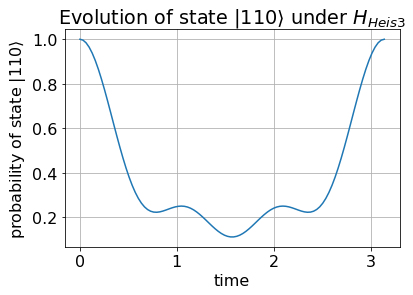

In [ ]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

### 1-5 Decomposition of $U_{\text{Heis3}}(t)$ Into Quantum Gates

To execute $U_{\text{Heis3}}(t)$ on a [circuit model](https://qiskit.org/documentation/apidoc/circuit.html) quantum computer, we must decompose $U_{\text{Heis3}}(t)$ into a product of single and two-qubit gates that are native to that quantum computer. There are a [variety of techniques](https://en.wikipedia.org/wiki/Hamiltonian_simulation) to do this. For this Open Science Prize, you will only use [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas) (which is sometimes refered to as Suzuki-Trotterization decomposition, Trotter formulas, product formulas, and other names).

Below, we show an example Trotterization as outlined in \[1-2\].

Since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other, the exponential $U_{\text{Heis3}}(t)$ cannot be split into a product of simpler exponentials. However, we can approximate $U_{\text{Heis3}}(t)$ as a product of simpler exponentials through Trotterization. Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. Rewritting $U_{\text{Heis3}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{Heis3}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right].
$$

$H^{(0,1)}_{\text{Heis2}}$ and $H^{(1,2)}_{\text{Heis2}}$ do not commute, so $U_{\text{Heis3}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{Heis2}}\right) \exp\left(-i t H^{(1,2)}_{\text{Heis2}} \right)$. But, this product decomposition can be approximated with Trotterization which says $U_{\text{Heis3}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{Heis2}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{Heis2}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how a untiary is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means we can decompose the exponential of a subsystem Hamiltonian ($H^{(i,j)}_{\text{Heis2}}$) into a product of even simpler exponentials getting us closer to a gate implementation of $U_{\text{Heis3}}(t)$

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}\right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)\right)\right]^{n} \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n}
\end{align}
$$

For simplicity, and to use more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$ and rewrite the Trotterized $U_{\text{Heis3}}(t)$
$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n}
$$
And that's it! We have now approximately decomposed $U_{\text{Heis3}}(t)$ into two-qubit gates $XX(t)$, $YY(t)$, and $ZZ(t)$. These gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates with *further details found in the supplementary material.*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]


### 1-1 Quantum Simulation
One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation (details in Section 2).

The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum [spin-1/2](https://en.wikipedia.org/wiki/Spin-1/2) particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, [certain optimization problems can be mapped](https://arxiv.org/pdf/1712.05771.pdf) to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.

There are many different spin models, but we will focus on the [$XXX$ Heisenberg spin model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#XXX_model). Though it is not as well known as the [transverse-field Ising model](https://en.wikipedia.org/wiki/Transverse-field_Ising_model), the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.

The notebook is organized as follows:
1) Section 1 (labeled 1-X) provides you with brief introductions to the $XXX$ Heisenberg model, time evolving a Hamiltonian, and decomposing a time evolution operator into gates for a quantum computer to execute.
2) Section 2 (labeled 2-X) outlines the specific requirements and boundaries associated with completing and competing in the Open Science Prize. Continuing from Section 1, the notebook showns an example solution.

# 2 The Open Science Prize (please run, no need to open)

### 2-1 Contest Details
The Open Science Prize requirements and judging criteria can be found in the terms and conditions when registering on the [website](https://ibmquantumawards.bemyapp.com/#/event). Below is an outline of those requirements.

You are to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$ as defined in Section 1. This will be done on the ibmq_jakarta quantum computer. From left to right, the qubits in $|110\rangle$ correspond to ibmq_jakarta's qubits 5, 3, and 1. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$). You will be judged on the clarity, originiality, and creativity of your solution, as well as the fidelity of the evolved state at time $t=\pi$ using [state tomography](https://qiskit.org/documentation/tutorials/noise/8_tomography.html). State tomography is a way of determining the exact quantum state--even phase information--at the end of a quantum circuit by running the circuit multiple times and measuring in different bases. The closer your final quantum state to the expected state, the higher the fidelity. Ibmq_jakarta's qubits 0, 2, 4, and 6 will not be evaluated by the state tomography calculation, so you may use them as you wish. You do not need to follow the same decomposition given in the example above, but your solution must be a Trotterization of $U_{\text{heis3}}(t)$ with at least 4 steps ($n\geq4$). You may find it useful to implement techniques that reduce errors and improve qubit coherence.

### 2-2 Import Qiskit

Feel free to import packages as needed. However, only free packages and those obtained through ```pip install``` or ```conda install``` are allowed.

In [ ]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 2-3 Quantum Devices
Connect to IBM provider and connect to a real or simulated backend. Final submissions must be run on a real backend, but simulated devices are faster for debugging and testing.

In [ ]:
# load IBMQ Account data

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-24 03:36:00,630: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

### 2-4 Decomposition of $U_{\text{Heis3}}(t)$ into Quantum Gates (Example)

The following circuit code is written based on the example given in Section 1. This is where you write your solution.

YOUR TROTTERIZATION GOES HERE -- START (beginning of example)

In [ ]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [ ]:
# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

In [ ]:
# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

In [ ]:
# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

Combine subcircuits into single gate representing one ($n=1$) trotter step.

In [ ]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

YOUR TROTTERIZATION GOES HERE -- FINISH (end of example)

### 2-5 Trotterized Time Evolution

Time evolve the state $|110\rangle$ from $\theta=0$ to $\theta=\pi$ under $H_{\text{heis3}}$. Although jakarta has 7 qubits, only the qubits 1, 3, and 5 will be used for the state $|110\rangle$. From left to right, the qubits in $|110\rangle$ corresponds to the qubits 5, 3, and 1 on jakarta. State tomography will evaluate how well the quantum simulation matches to the expected state at $\theta= \pi$. (Note qubits 0, 2, 4, and 6 are not part of the state tomography calculation.)

You choose how many trotter steps (```trotter_steps```) to take in the simulation, but it must be at least 4. The code below is written to be generic enough for you may add to it if necessary for your solution.

In [ ]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 3  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw()  # only view trotter gates

░          
q4_0: ────────────────────────────────────────────────░──────────
           ┌────────────┐┌────────────┐┌────────────┐ ░ ┌─┐      
q4_1: ─────┤0           ├┤0           ├┤0           ├─░─┤M├──────
           │            ││            ││            │ ░ └╥┘      
q4_2: ─────┤            ├┤            ├┤            ├─░──╫───────
      ┌───┐│            ││            ││            │ ░  ║ ┌─┐   
q4_3: ┤ X ├┤1 Trot(π/3) ├┤1 Trot(π/3) ├┤1 Trot(π/3) ├─░──╫─┤M├───
      └───┘│            ││            ││            │ ░  ║ └╥┘   
q4_4: ─────┤            ├┤            ├┤            ├─░──╫──╫────
      ┌───┐│            ││            ││            │ ░  ║  ║ ┌─┐
q4_5: ┤ X ├┤2           ├┤2           ├┤2           ├─░──╫──╫─┤M├
      └───┘└────────────┘└────────────┘└────────────┘ ░  ║  ║ └╥┘
q4_6: ────────────────────────────────────────────────░──╫──╫──╫─
                                                      ░  ║  ║  ║ 
c0: 3/═══════════════════════════════════════════════════╩══╩══╩═
                                                         0  1  2

### 2-6 Execute
For your final submission, you will need to execute your solution on a real backend with 8 repetitions. For faster debugging, considering using a simulated backend and/or 1 repetition.

In [ ]:
shots = 1024 #8192
reps = 1 #8
backend_sim = sim_noisy_jakarta
# backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend_sim, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 9479c211-c318-4958-b172-de899ad58a14


We can monitor the status of the jobs using Qiskit's job monitoring tools.

In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run


### 2-7 Results Analysis
Extract the results for the completed jobs and compute the state tomography fidelity for each repetition. You may choose to include other post-processing analyses here as well.

In [ ]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.0798 ± 0.0000


OpenScience_2022_ver1.0.ipynb

# 3 Step-by-step description of the proposed solution

Below we outline the key feature of the approach that was taken, along with the main benefits of the solution.



##3.1   Pulse-level optimization of $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gates (expand for details)

The two-qubit (2q) gates $XX$, $YY$, and $ZZ$ are the main source of errors in the quantum circuit. The errors come both from the limited fidelity of the gates themselves, as well as from their long duration (causing decoherence on idling qubits). We have tackled this part of the problem by designing the shortest possible $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gates by rescaling the standard $ZX$ pulses and designing their optimal decompositions into one-qubit (1q) and $ZX(\theta)$ pulses.

Motivated by the work of [Earnest *et al.*](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043088), which first proposed the implementation of pulse-efficient transpilation of the $ZZ(\theta)$ gate, we have improved their strategy and extended it to $XX(\theta)$ and $YY(\theta)$ gates.

###3.1.1 $ZX$ pulse rescaling

The default decomposition of a $ZZ(\theta)$ gate consists of an $R_z(\theta)$ gate sandwitched between two CNOT gates. Each CNOT gate is in turn composed of $ZX(\pi/4)$ and $ZX(-\pi/4)$ cross-resonance pulses and several 1q gates. The idea is to decompose, e.g., $XX(\theta)$ into 1q gates plus just two 2q pulses: $ZX(\theta/2)$ and $ZX(-\theta/2)$. To obtain the $ZX(\theta/2)$ pulse, we rescale the default pre-calibrated $ZX(\pi/4)$ cross-resonance pulse by extracting it from the decault CNOT schedule and changing its duration, such that:

$\frac{\theta/2}{\pi/4} = \frac{\mathrm{Area}(ZX(\theta/2))}{\mathrm{Area}(ZX(\pi/4))}$, 

$\mathrm{Area}(ZX(\pi/4)) = |A^*|\left[w^* + \sqrt{2\pi}\sigma\,\mathrm {Erf}(n_\sigma/\sqrt{2})\right]\,,$

$\mathrm{Area}(ZX(\theta/2)) = |A^*|\left[w(\theta/2) + \sqrt{2\pi}\sigma\,\mathrm {Erf}(n_\sigma/\sqrt{2})\right]\,,$

where $A^*$ and $w^*$ is the calibrated amplitude and width of the default $ZX(\pi/4)$ pulse, $n_\sigma \sigma$ is the risefall duration of the GaussianSquare pulse, and $w(\theta/2)$ is the desired rescaled width of the $ZX(\theta/2)$ pulse.


Note that each $ZX$ pulse is accompanied by 1q rotary tones that are also rescaled in same way. To avoid nonlinearities between the rotation angle $\theta$ and pulse parameters, the amplitudes of all rescaled pulses is kept fixed, and only the width is changed.

The final expression implemented in the function ``rescale_cr()`` is:

$w(\theta/2) = \frac{2\theta}{\pi} w^* + \left(\frac{2\theta}{\pi} - 1\right)\sqrt{2\pi}\sigma\,\mathrm {Erf}(n_\sigma/\sqrt{2})$,

which indeed gives $w(\pi/4) = w^*$.

When the desired $\theta$ angle is too small to be able to achieve it by just reducing the width of the GaussianSquare pulse, we rescale the amplitude of the pulse as well (not necessary for the this challenge).


Below we demonstrate the approach for the $XX(\pi)$ gate on *ibmq_jakarta* qubits [3,5], comparing the default implementation with ours (see more on how we obtained the custom $XX$, $YY$, and $ZZ$ gate decompositions in Section 3.1.2).

Default $XX(\pi)$:

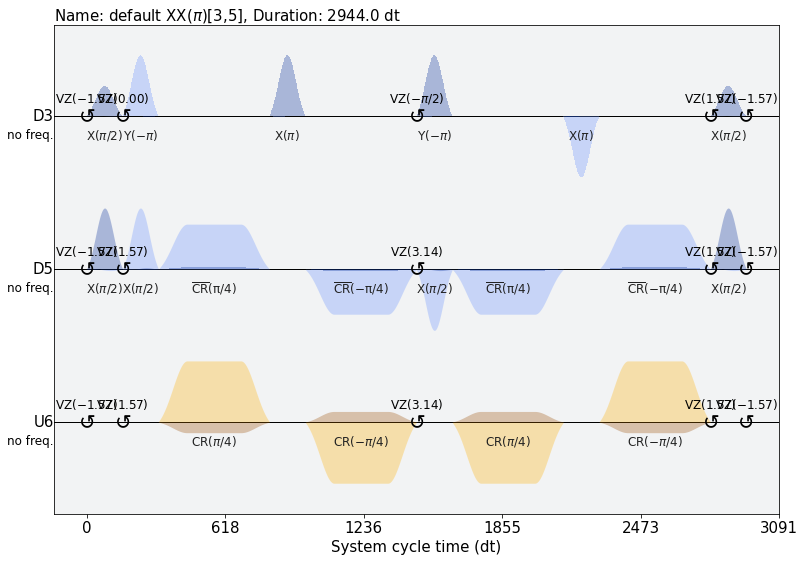

In [ ]:
q0, q1 = 3, 5
theta = np.pi

qc = QuantumCircuit(7, name=f'default XX($\pi$)[{q0},{q1}]')
# default XX gate
qc.ry(np.pi/2,[q0,q1])
qc.cnot(q0,q1)
qc.rz(theta, q1)
qc.cnot(q0,q1)
qc.ry(-np.pi/2,[q0,q1])

# create pulse schedule for QPT
sched_default = schedule(transpile(qc, backend, optimization_level=1), backend)
sched_default.draw()

Custom $XX(\pi)$:

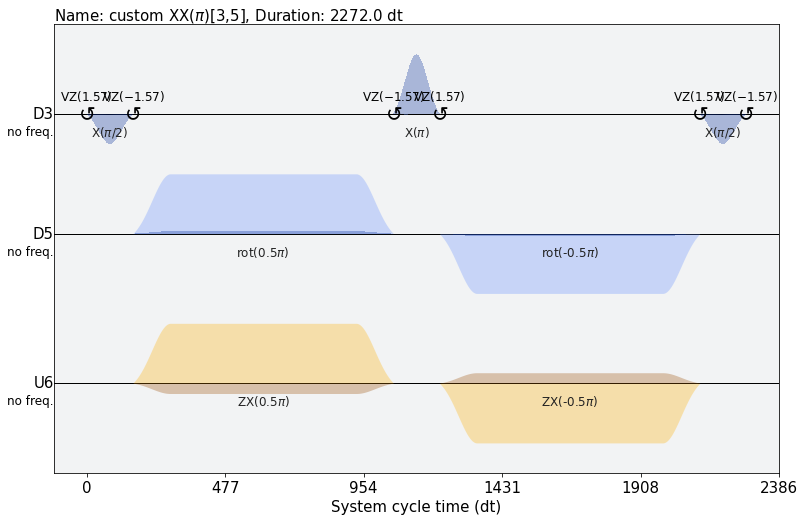

In [ ]:
qc = QuantumCircuit(7, name=f'custom XX($\pi$)[{q0},{q1}]')
### custom ZX(pi) schedule

# this function extracts CR pulses with rotary correction tones from default CNOTs.
sched_CR = cr_from_cx(q0, q1, "CRp")

# this function generates rescaled ZX(theta) pulses from the CR ZX(pi/4) schedule,
# with positive or negative amplitudes (CRp/CRm). Regarding the adjust_amp argument, see the note below.
sched_crp = rescale_cr(sched_CR, theta, 'CRp', adjust_amp=True)
sched_crm = rescale_cr(sched_CR, theta, 'CRm', adjust_amp=True)

sched_ZX = Schedule(name=f'ZX[{q0},{q1}]')
sched_ZX |= sched_crp                                                                           # CRp
sched_ZX |= inst_map.get('u1', P0=-np.pi/2, qubits=(q0)) << sched_ZX.duration                    # Z(-pi/2)_q0
sched_ZX |= inst_map.get('x', qubits=(q0)) << sched_ZX.duration                                  # X_q0
sched_ZX |= inst_map.get('u1', P0=np.pi/2, qubits=(q0)) << sched_ZX.duration                     # Z(pi/2)_q0
sched_ZX |= sched_crm << sched_ZX.duration                                                       # CRm

# custom XX gate
ZX_gate = Gate('ZX', 2, [])
qc.ry(-np.pi/2, q0)
qc.append(ZX_gate, [q0, q1])
qc.ry(-np.pi/2, q0)
qc.add_calibration(ZX_gate, (q0, q1), sched_ZX)

# create pulse schedule for QPT
sched_custom = schedule(transpile(qc, backend, optimization_level=1), backend)
sched_custom.draw()

As you can see, the default decomposition of $XX(\pi)$ is 30% (672 samples) longer than our custom one. In addition, our custom gate requires only **three** 1q gates, as opposed to **ten** 1q gates in the default decomposition. The reduction in duration enabled by the custom $XX(\theta)$ decomposition depends on the duration of the default calibrated CR pulse (which is generally different for every pair of connected qubits on the device), and on the rotation angle $\theta$. The shorter the default CR pulse, and the smaller the angle - the greater the relative reduction in $XX$ gate duration. Note that our custom $XX$ gate decomposition can never be longer that the default one. At worst, the two are equal, when $\theta = 2\pi$. However, e.g., for *ibmq_jakarta* qubits [0,1], the custom decomposition of $XX(\pi/2)$ is twice (!) shorter than the default one (1216 vs. 2432 samples).

Let us verify that our decomposition indeed produces the $XX(\pi)$ gate:

Load experiment result (6259e36ff1fb8d8fe03ad384)
(readout fidelity = 0.940)


findfont: Font family ['Noto Mono'] not found. Falling back to DejaVu Sans.


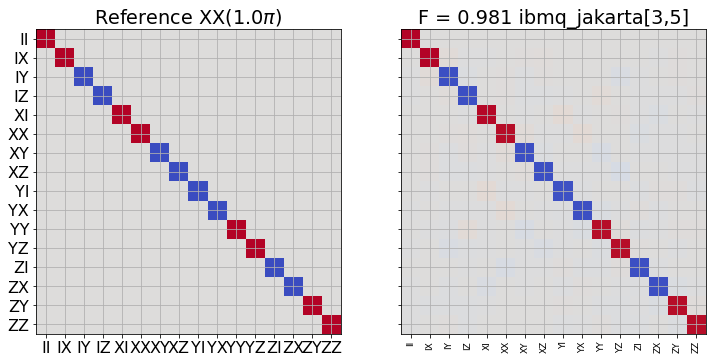

QPT process fidelity = 9.810e-01


0.980973859473494

In [ ]:
job_id = '6259e36ff1fb8d8fe03ad384' # jakarta, custom XX(pi)
# define the 2q schedule to perform QPT on
test_sched = sched_custom

shots=8192
rep_delay=50e-6
gate_type='XX'
theta = np.pi
run_qpt(backend, (q0, q1), test_sched, rep_delay, shots, job_id, gate_type, theta)

Load experiment result (6259e36ff1fb8d8fe03ad384)

(readout fidelity = 0.940)

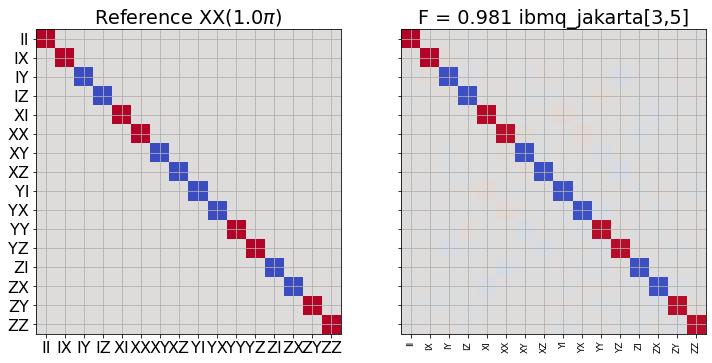

QPT process fidelity = 9.810e-01

The default $XX(\pi)$ performs similarly:

Load experiment result (6259e31e35e1ec522d2531d4)
(readout fidelity = 0.934)


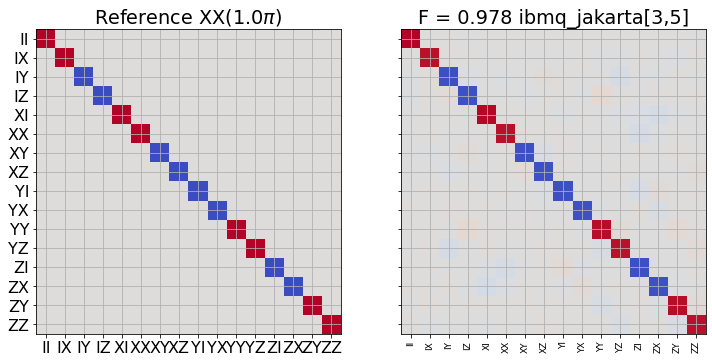

QPT process fidelity = 9.782e-01


0.9781712755251242

In [ ]:
job_id = '6259e31e35e1ec522d2531d4' # jakarta, default XX(pi)
test_sched = sched_default

shots=8192
rep_delay=50e-6
gate_type='XX'
theta = np.pi
run_qpt(backend, (q0, q1), test_sched, rep_delay, shots, job_id, gate_type, theta)

Load experiment result (6259e31e35e1ec522d2531d4)

(readout fidelity = 0.934)

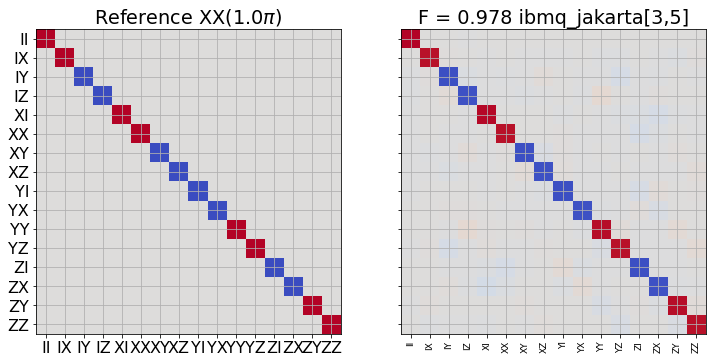

QPT process fidelity = 9.782e-01

Both decompositions offer similar QPT process fidelities ~0.98 after measurement error mitigation.

Notes:
*   Because the duration of all pulses must be a multiple of 16 samples, we have added an argument *adjust_amp* to the ``rescale_cr()`` function that allows to slightly rescale the amplitudes of pulses to exactly match the desired area of the custom $ZX(\theta/2)$ rescaled pulses. The typical adjustment is small, $\lesssim 1\%$.

*   We believe that the paper by [Earnest *et al.*](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043088) contains an error/typo in the Section *SCALING HARDWARE-NATIVE CROSS-RESONANCE GATES*, where the expression for the rescaling should read $|A(\theta)| = \alpha(\theta)/\left[\sigma\sqrt{2\pi}\,\text{erf}(n_\sigma\mathbf{/\sqrt{2}})\right]$ instead of $|A(\theta)| = \alpha(\theta)/\left[\sigma\sqrt{2\pi}\,\text{erf}(n_\sigma)\right]$. We will note that having tested both implementations and compared the rescaled pulses, the difference between the two is minor, $<1\%$.

*   In order to re-run 2q QPT experiments, you need to set job_id = ' ' (empty string), and the ``run_qpt()`` function will run a new QPT job.

###3.1.2 Custom decomposition into 1q and $ZX$ gates

In order to construct the custom $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gate decompositions into 1q and rescaled $ZX(\theta)$ gates, we have developed a search algorithm allowing to perform the search of 1q unitary gates $U_1\cdots U_6$, such that the total 2q unitary is equivalent to the desired gate. The details of the algorithm are beyond the scope of this submission. The search was performed based on the following shape of the target 2q gate:

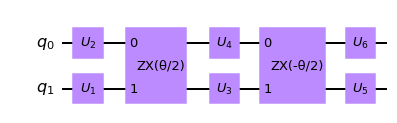

Prioritizing the solutions with the most *Id* and $R_z$ (zero-duration, virtual) gates, we found:
*   2 decompositions of the $XX(\theta)$ gate with 3 $R_x$ or $R_y$ pulses
*   2 decompositions of the $YY(\theta)$ gate with 3 $R_x$ or $R_y$ pulses
*   8 decompositions of the $ZZ(\theta)$ gate with 4 $R_x$ or $R_y$ pulses

The variety of these custom decompositions allows to achieve additional circuit depth reduction by occasional cancellations of 1q gates when stringing several of these gates together. For example, the circuits for $XX(\pi)[3,5]$ (version #1) and $ZZ(\pi)[1,3]$ (version #1) look like this:


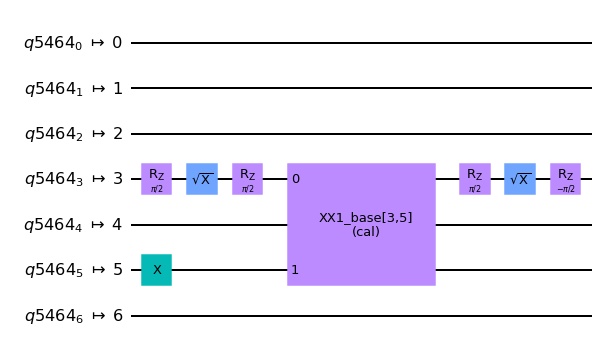

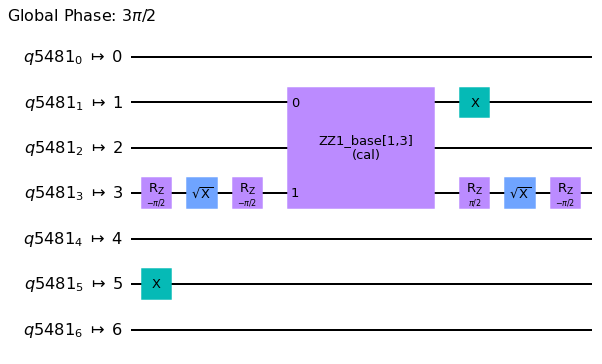

But when put together, the $R_y(-\pi/2)$ and $R_y(\pi/2)$ gates on Q3 between them cancel out: 

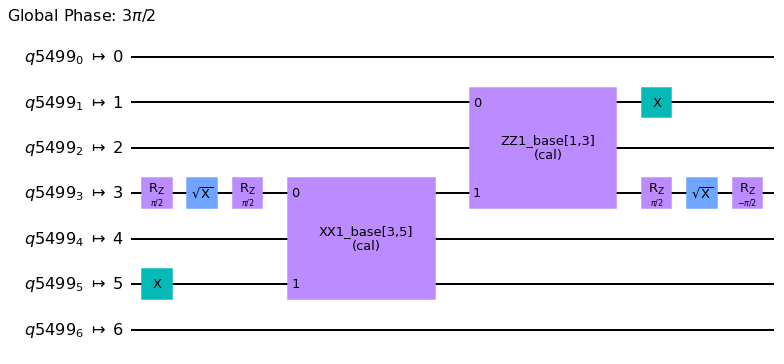

(In case the above images do not show correctly, they are also attached to the submission, see Fig. 1)

This strategy is important for further bringing down the number of 1q gates in the Trotter circuit by choosing the optimal order of $XX$, $YY$, and $ZZ$ gates. Our strategy for this is procedure described in Section 3.3.

Notes:

*   It is fundamentally important that the custom $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gate decompositions that we have proposed in this work do not come with any additional calibration overhead, and are fully based on the default calibrated $ZX(\pi/4)$ cross-resonance pulses extracted from CNOT gates.

*   During the search for custom decompositions, we had to take into account the presence of rotary correction tones that are played in parallel with CR pulses, in order to obtain decompositions that are robust against arbitrary amplitudes of these correction tones.

*   Below we provide all found decompositions with the minimum number of 1q pulses.
The decompositions below list 1q gates in the order ${[U_1, U_2, U_3, U_4, U_5, U_6]}$:

$XX(\theta)$:
1.   [$Id$,       $R_y(-\pi/2)$, $Id$, $R_y(\pi)$, $Id$,       $R_y(-\pi/2)$]
2.   [$R_z(\pi)$, $R_y(\pi/2)$,  $Id$, $R_y(\pi)$, $R_z(\pi)$, $R_y(\pi/2)$] 

$YY(\theta)$:
1.   [$R_z(-\pi/2)$, $R_x(\pi/2)$,  $Id$, $R_x(\pi)$, $R_z(\pi/2)$,  $R_x(\pi/2)$]
2.   [$R_z(\pi/2)$,  $R_x(-\pi/2)$, $Id$, $R_x(\pi)$, $R_z(-\pi/2)$, $R_x(-\pi)$]

$ZZ(\theta)$:
1.   [$R_y(\pi/2)$,  $Id$,       $Id$, $R_x(\pi)$, $R_y(-\pi/2)$, $R_x(\pi)$]
2.   [$R_y(\pi/2)$,  $Id$,       $Id$, $R_y(\pi)$, $R_y(-\pi/2)$, $R_y(\pi)$]
3.   [$R_y(\pi/2)$,  $R_z(\pi)$, $Id$, $R_x(\pi)$, $R_y(-\pi/2)$, $R_y(\pi)$]
4.   [$R_y(\pi/2)$,  $R_z(\pi)$, $Id$, $R_y(\pi)$, $R_y(-\pi/2)$, $R_x(\pi)$]
5.   [$R_y(-\pi/2)$, $R_x(\pi)$, $Id$, $R_x(\pi)$, $R_y(\pi/2)$,  $Id$]   
6.   [$R_y(-\pi/2)$, $R_x(\pi)$, $Id$, $R_y(\pi)$, $R_y(\pi/2)$,  $R_z(\pi)$]
7.   [$R_y(-\pi/2)$, $R_y(\pi)$, $Id$, $R_x(\pi)$, $R_y(\pi/2)$,  $R_z(\pi)$]
8.   [$R_y(-\pi/2)$, $R_y(\pi)$, $Id$, $R_y(\pi)$, $R_y(\pi/2)$,  $Id$]   


##3.2   Four-step Trotterization with optimized durations (expand for details)


For the purpose of this challenge, we chose to use the 1st order Trotter decomposition. While in certain cases it is benefitial to use higher-order Lie-Trotter-Suzuki decompositions for non-commuting Hamiltonian terms, ultimately they increase the number of $XX$, $YY$, and $ZZ$ gates to be executed. Therefore, as long as the 1st-order scheme provides in theory a near-perfect solution, higher-order Trotterization is redundant and will only reduce the fidelity on QPU due to increased circuit depth.

It is easy to show that 1st-order Trotterization with 4 equal evolution steps, $t = \pi/4$ each, yields poor results even in theory. In fact, instead of the |110> state, the naive 4-step Trotterization scheme evolves the system to the |011> state after $t = \pi$. However, the rules of the challenge do not require all Trotter steps to evolve the system by the same amount of time. Therefore, let us find how to optimally split the total duration of $\pi$ into 4 steps such that the fidelity of the final $|110>$ state is maximized.

We construct the 4-step Trotter scheme such that the total duration of $\pi$ is split into 4 consecutive intervals of durations {$a_1$, $a_2$, $a_3$, $a_4$}*$\pi$. This gives us 3 independent variables, because $a_1 + a_2 + a_3 + a_4 = 1$. The corresponding quantum circuits can be easily constructed and simulated. Figure 2 (attached) shows the results of the simulations as a 3-dimensional plot, with {$a_1$, $a_2$, $a_3$) along the axes, and color representing the simulated fitelity of observing the target $|110>$ state at the end of the evolution. The plot shows that the highest fidelity is achieved in two cases:


1.   One of the elements {$a_1$, $a_2$, $a_3$, $a_4$} is equal to 1 (and the rest must be 0), e.g. {1,0,0,0}
2.   Two of the elements {$a_1$, $a_2$, $a_3$, $a_4$} are equal to 0.5 (and the other two are 0), e.g. {0.5,0.5,0,0}

The first option would reduce the Trotter evolution to 4 Trotter steps, with 3 of them being zero-duration. The single non-zero step will evolve the system by $t = \pi$, using in $XX(2\pi)$, $YY(2\pi)$, and $ZZ(2\pi)$ gates (assuming the 1st-order Trotter scheme). Unfortunately, $XX$, $YY$, and $ZZ$ are $2\pi$-periodic (up to a sign), which trivializes this approach to essentially not evolving the system at all. We disregard this possibility as trivial.

The second option is different. With two $t \simeq \pi/2$ and two $t \simeq 0$ Trotterization steps, the system actually evolves along the path that only slightly deviates from the exact solution. Let us illustrate this by considering the system's evolution with the given problem Hamiltonian but for a range of durations from $t = 0$ to $t = \pi$.



###3.2.1 Auxiliary functions and simulations for the comparison below
Executing is not required, proceed to the next Section

In [ ]:
# Parameterize variable t to be evaluated at t=pi later
t1 = Parameter('t1')
t2 = Parameter('t2')

# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX1')
XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t1, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX1 = XX_qc.to_instruction()

# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX2')
XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t2, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])
# Convert custom quantum circuit into a gate
XX2 = XX_qc.to_instruction()

# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY1')
YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t1, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY1 = YY_qc.to_instruction()

# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY2')
YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t2, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY2 = YY_qc.to_instruction()
# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ1')
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t1, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ1 = ZZ_qc.to_instruction()

# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ2')
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t2, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ2 = ZZ_qc.to_instruction()

In [ ]:
# define the range of total evolution durations for the experiment
n_times = 20
times_list = np.linspace(0, target_time, n_times)

target_time = np.pi
backend_sim = Aer.get_backend('aer_simulator')
shots = 1024 #8192

# define Trotter evolution gates for the first two (t = np.pi/2) and last two (t = 0) steps
num_qubits = 3
Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
Trot_qc.append(XX1, [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(ZZ1, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(XX1, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(YY1, [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(YY1, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(ZZ1, [Trot_qr[1], Trot_qr[2]])
Trot_gate1 = Trot_qc.to_instruction()

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
Trot_qc.append(XX2, [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(ZZ2, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(XX2, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(YY2, [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(YY2, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(ZZ2, [Trot_qr[1], Trot_qr[2]])
Trot_gate2 = Trot_qc.to_instruction()

 (part commented out, takes several minutes to run):

In [ ]:
# Trotter steps: {a1, a1, a2, a2}*np.pi
a1, a2 = 0.5, 0

fids_list = []
for i, final_time in enumerate(times_list):
    print(f"i = {i + 1}/{n_times}")
    qr = QuantumRegister(7)
    qc_default = QuantumCircuit(qr)

    qc_default.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # assemble the 4-step Trotter evolution
    qc_default.append(Trot_gate1, [qr[1], qr[3], qr[5]])
    qc_default.append(Trot_gate2, [qr[1], qr[3], qr[5]])
    qc_default.append(Trot_gate2, [qr[1], qr[3], qr[5]])
    qc_default.append(Trot_gate1, [qr[1], qr[3], qr[5]])

    qc_default = qc_default.bind_parameters({t1: final_time*a1, t2: final_time*a2})
    
    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_default, [qr[1], qr[3], qr[5]])

#     jobs = []
#     for _ in range(reps):
#         job = execute(st_qcs, backend_sim, shots=shots)
#         jobs.append(job)

#     # Compute tomography fidelities for each repetition
#     fids = []
#     for job in jobs:
#         fid = state_tomo(job.result(), st_qcs)
#         fids.append(fid)        
#     fids_list.append(np.mean(fids))
# print(f"fids_list = {fids_list}")

Modified trotterization scheme testing the effect of small deviations from the [0.5, 0, 0, 0.5] scheme (commented out, takes several minutes to run):

In [ ]:
# Trotter steps: {a1, a1, a2, a2}*np.pi
a1, a2 = 0.49, 0.01

fids_list_deviation = []
for i, final_time in enumerate(times_list):
    print(f"i = {i + 1}/{n_times}")
    qr = QuantumRegister(7)
    qc_default = QuantumCircuit(qr)

    qc_default.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # assemble the 4-step Trotter evolution
    qc_default.append(Trot_gate1, [qr[1], qr[3], qr[5]])
    qc_default.append(Trot_gate2, [qr[1], qr[3], qr[5]])
    qc_default.append(Trot_gate2, [qr[1], qr[3], qr[5]])
    qc_default.append(Trot_gate1, [qr[1], qr[3], qr[5]])

    qc_default = qc_default.bind_parameters({t1: final_time*a1, t2: final_time*a2})
    
    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_default, [qr[1], qr[3], qr[5]])

#     jobs = []
#     for _ in range(reps):
#         job = execute(st_qcs, backend_sim, shots=shots)
#         jobs.append(job)

#     # Compute tomography fidelities for each repetition
#     fids = []
#     for job in jobs:
#         fid = state_tomo(job.result(), st_qcs)
#         fids.append(fid)        
#     fids_list_deviation.append(np.mean(fids))
# print(f"fids_list_deviation = {fids_list_deviation}")

###3.2.2 Comparison with exact solution

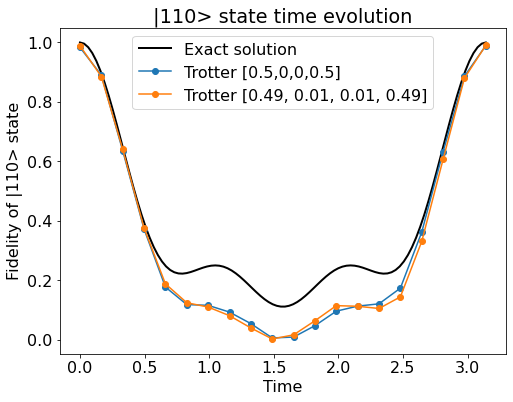

In [ ]:
# computed previously using the subsection above.
fids_list = [0.9832190769935109, 0.8901029780538571, 0.6360525240307021, 0.37223189369929344, 0.17717178899994476, 0.11821661607000253, 0.11567643521925715, 0.09288772754391876, 0.05416453170794114, 0.006035356052706257, 0.00884195349232517, 0.047243593633900155, 0.09602256492977784, 0.11302087728860584, 0.12073970201842027, 0.1734970149273126, 0.3618771025424155, 0.6323619001405626, 0.8864439749903558, 0.989615229534766]
fids_list_deviation = [0.9886774562332744, 0.8854337529257371, 0.6407949055198421, 0.37545079215350063, 0.18785617236277047, 0.12441594094276787, 0.10991554531831099, 0.08089747942882886, 0.03965663400583641, 0.0025068474976234255, 0.01635772077027647, 0.06376365199391908, 0.1146150050592779, 0.11257114880713862, 0.10503723970393486, 0.1441471828005607, 0.33043218999605056, 0.6067493653996446, 0.8799367018863941, 0.9904241697958286]

times_list = np.linspace(0, target_time, 20)
ts_ideal = np.linspace(0, np.pi, 100)
initial_state = One^One^Zero
probs_110_ideal = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts_ideal]

figure(figsize=(8, 6))
plt.plot(ts_ideal, probs_110_ideal, linewidth=2, c='black', label='Exact solution')
plt.plot(times_list, fids_list, 'o-', label=f"Trotter [0.5,0,0,0.5]")
plt.plot(times_list, fids_list_deviation, 'o-', label=f"Trotter [0.49, 0.01, 0.01, 0.49]")
plt.title(f"|110> state time evolution")
plt.xlabel("Time")
plt.ylabel("Fidelity of |110> state")
plt.legend(loc="upper center")
plt.show()

Not only does the 4-step Trotter scheme {0.5,0,0,0.5} agree reasonably well with exact simulations, considering the number of steps, but the above plot also shows that this scheme is robust against small deviations from {0.5, 0, 0, 0.5}. One can easily show that this is not unique to the evolution of the |110> state. This confirms that the 2-step Trotterization approximates the evolution of the Hamiltonian well. In order to satisfy the rules of the competition, two additional steps evolving the system by $t = 0$ can be added, as long as all 1q gates in these zero-duration layers are still executed. We make sure that this is satisfied during circuit transpilation by creting custom $XX$, $YY$, and $ZZ$ gates at pulse level that do not allow the zero-duration layers to be cancelled out, which we will demonstrate below in the Section 3.3.

Notes:

*   **I asked AJ Rasmusson in a direct message on Slack whether it would be acceptable to use 4-step Trotterization with 2 zero-duration steps (as long as all the 1q gates in those layers are still executed), and he confirmed that "such a strategy is within the rules of the competition."**



##3.3   Optimized order of XX, YY, and ZZ gates in each Trotter layer (expand for details)

As illustrated previously in Section 3.1.2, it is possible to shorten the circuit by finding an optimal order of $XX$, $YY$, and $ZZ$ gates in each Trotter layer. This is because certain combinations of these 2q gates cancel out some of the 1q gates. We performed a complete search over all 720 permutations of {$XX[1,3]$, $YY[1,3]$, $ZZ[1,3]$, $XX[3,5]$, $YY[3,5]$, $ZZ[3,5]$} in a single Trotter layer and calculated the total duration of the corresponding pulse schedules (using Qiskit Pulse). 

For brevity, in what follows we shall adopt the following shorthand notations for $XX$, $YY$, and $ZZ$ gates between qubits [1,3] and [3,5]:

$ZZ[1,3]$ = X

$YY[1,3]$ = Y

$ZZ[1,3]$ = Z

$XX[3,5]$ = x

$YY[3,5]$ = y

$ZZ[3,5]$ = z

The order of these gates in a single Trotter layer can then be identified by a string, like 'xZXyYz', which is equivalent to the sequence of gates (left-to-right): $XX[3,5]$ --> $ZZ[1,3]$ --> $XX[1,3]$ --> $YY[3,5]$ --> $YY[1,3]$ --> $ZZ[3,5]$.

We have found 36 sequences that offer the shortest pulse schedule for the 4-step Trotterization scheme. To narrow down the pool of best candidate sequences, we have taken into account the fact that we are evolving the state |011>, meaning that Q1 is not initialized with an $X$ gate. We then prioritized only those sequences that start and end with a 2q gate on [3,5], further maximing the time interval during which Q1 remains in the |0> state. This left us with the following 8 sequences:
*   xZXYzy
*   xZXyYz
*   xZXzYy
*   xZYXzy
*   xZYyXz
*   xZYzXy
*   xZyXYz
*   xZyYXz

Each of these 2q gate sequences, repeated 4 times, generates the 4-step Trotterization circuit with a total duration of **33056** samples:

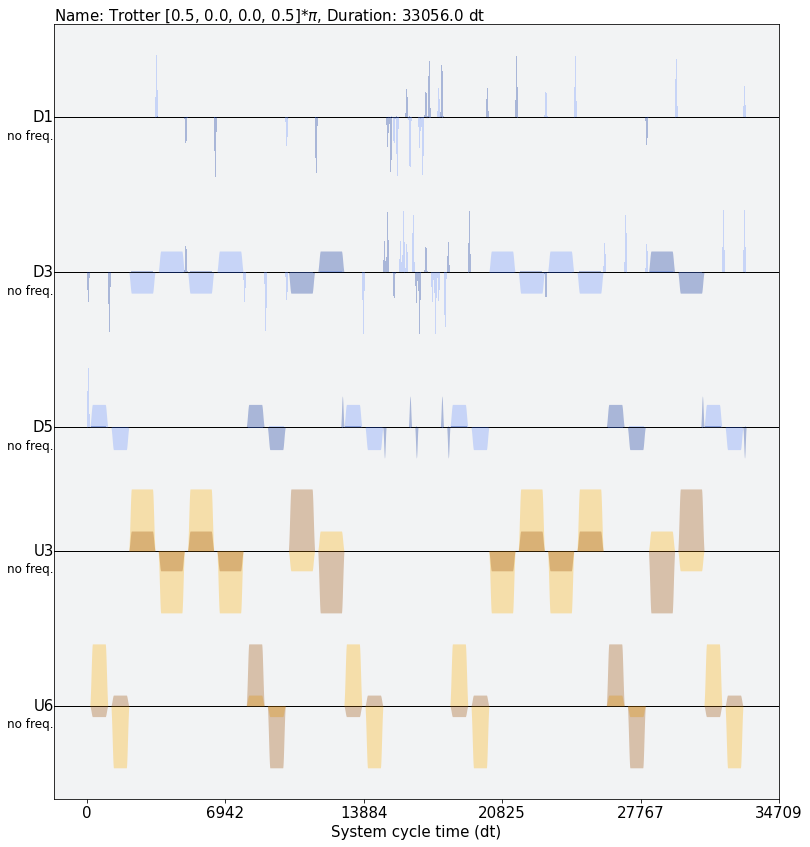

In [ ]:
qq = [1,3,5]

# optimal order of 2q gates in each Trotterization layer
seq = 'xZXyYz'

#list of individual durations of each Trotter step, for total evolution of t = pi in the case below.
theta_list = np.array([0.5, 0, 0, 0.5])*2*np.pi # the factor 2 is correct (each layer evolving the system by theta has XX(2*theta) gates)

qc_T = qc_Trot(seq, theta_list, qq)
#display(qc_T.draw())
circ_sched = schedule(qc_T, backend)
total_dur = circ_sched.duration
display(circ_sched.draw(show_waveform_info=False, show_framechange=False))

Here we chose to sandwitch the zero-duration layers between the other two. Let us illustrate here that all 1q pulses in the zero-duration layers are still there, to ensure that we comply with the rules of the Open Science Challenge. To show this, we have split up the entire duration of the pulse schedule: (0, 14848), (14848, 16448), (16448,18208), and (18208,33056). Because the drawer does not exactly follow the *time_range* argument, see the limits on the $x$ axis.

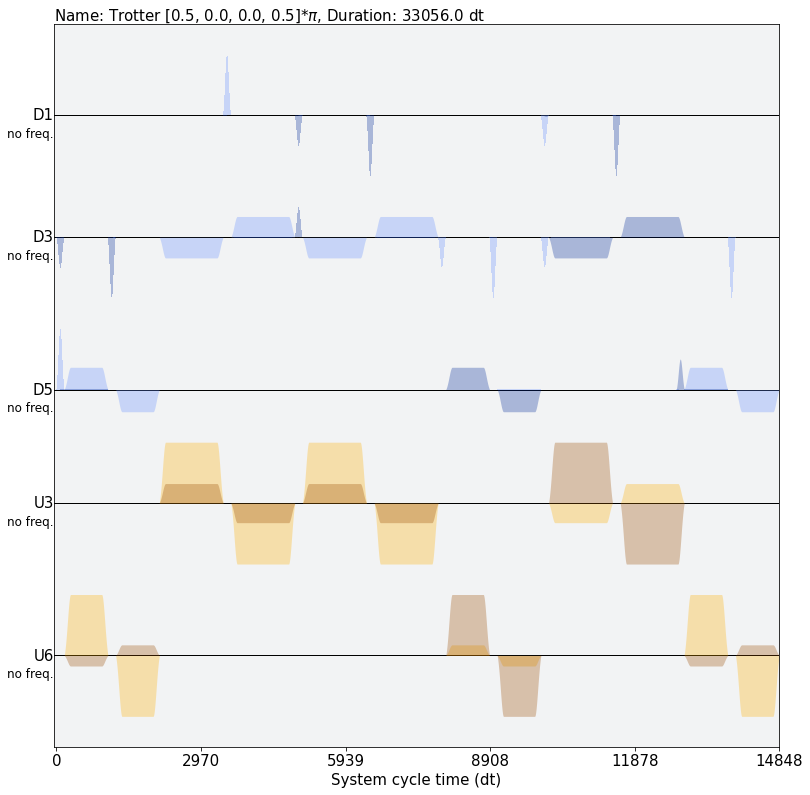

In [ ]:
display(circ_sched.draw(time_range=(620, 14170), show_waveform_info=False, show_framechange=False)) #(0, 14848)

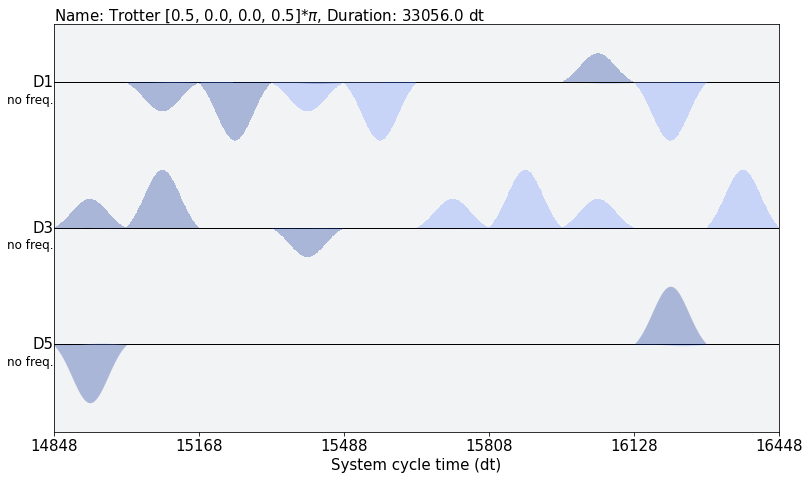

In [ ]:
display(circ_sched.draw(time_range=(14921, 16375), show_waveform_info=False, show_framechange=False)) #(14848, 16448)

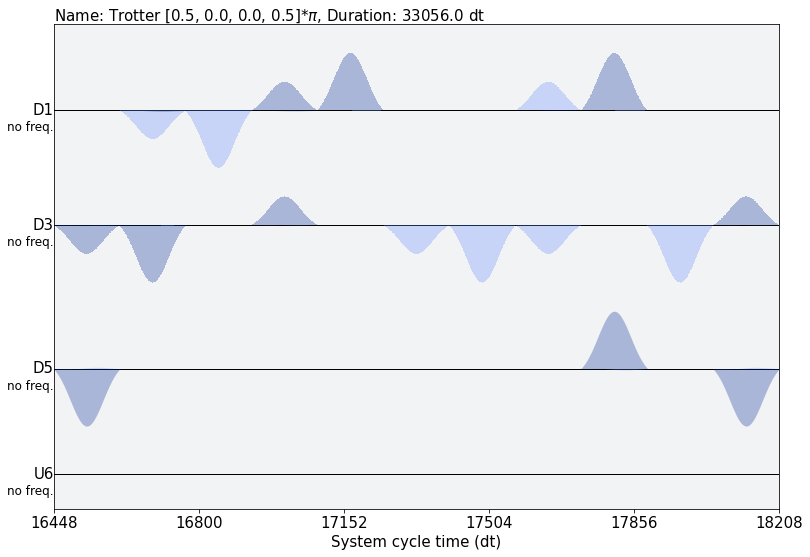

In [ ]:
display(circ_sched.draw(time_range=(16528, 18128), show_waveform_info=False, show_framechange=False)) #(16448, 18208)

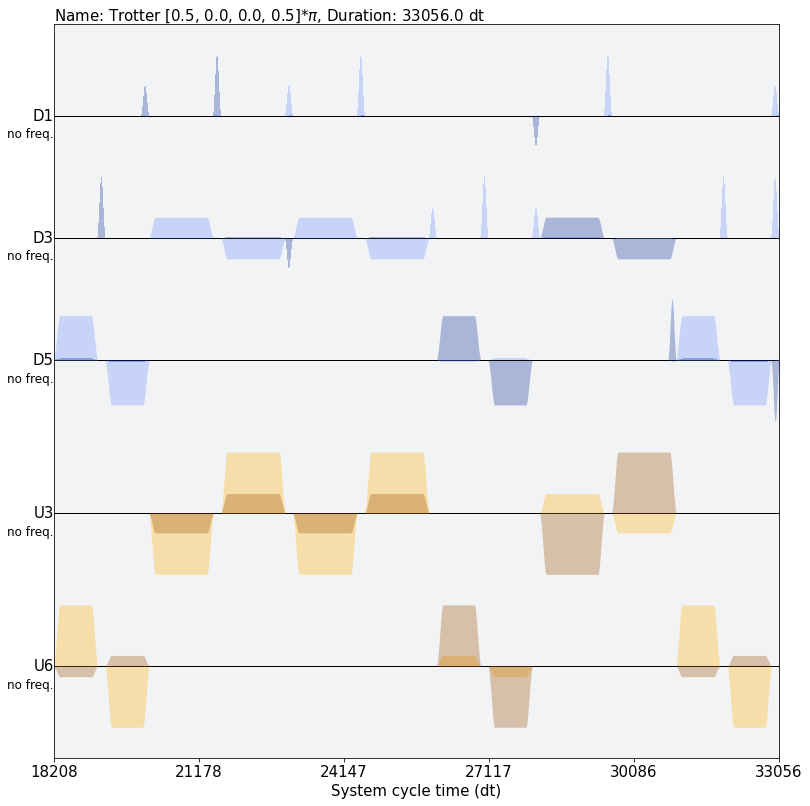

In [ ]:
display(circ_sched.draw(time_range=(18883, 32381), show_waveform_info=False, show_framechange=False)) #(18208, 33056)

As you can see, each Trotterization layer has approximately 6, 7, and 2 1q pulses on the DriveChannels for qubits 1, 3, and 5, correspondingly (due to transpilation, some pulses have jumped across these intervals without affecting the result, of course). Therefore, even zero-duration Trotterization steps are executed in full (CR and rotary pulses are absent because the duration of the evolution described by these layers is zero) without cancelling out any 1q gates, as designed.

Let us now compare out Trotterization circuit to its equivalent but executed using the default **default** $XX$, $YY$, and $ZZ$ gates. If you ran the Section 3.2.1, you already created this circuit. For this demonstration we chose the Trotterization with steps {0.49, 0.01, 0.01, 0.49}*$\pi$ instead of {0.5, 0, 0, 0.5}*$\pi$, in order to show the full duration of the default schedule. Had we inserted two zero-duration steps instead, they whould have been cabcelled out because $XX(0) = YY(0) = ZZ(0) = Id$. Note that circuit schedule durations of Trotter layers for any evolution time are the same, because $theta$ does not affect the duration of default $XX(\theta$) since the $\theta$ angles are inside virtual $R_z$ gates.

»
q2574_0: ──────────────────────────────────────────────────────────────»
              ┌───────────────────────┐┌──────────────┐┌──────────────┐»
q2574_1: ─────┤0                      ├┤0             ├┤0             ├»
              │                       ││              ││              │»
q2574_2: ─────┤                       ├┤              ├┤              ├»
         ┌───┐│                       ││              ││              │»
q2574_3: ┤ X ├┤1 Trot(1.539380400259) ├┤1 Trot(π/100) ├┤1 Trot(π/100) ├»
         └───┘│                       ││              ││              │»
q2574_4: ─────┤                       ├┤              ├┤              ├»
         ┌───┐│                       ││              ││              │»
q2574_5: ┤ X ├┤2                      ├┤2             ├┤2             ├»
         └───┘└───────────────────────┘└──────────────┘└──────────────┘»
q2574_6: ──────────────────────────────────────────────────────────────»
                                                                       »
«                                  
«q2574_0: ─────────────────────────
«         ┌───────────────────────┐
«q2574_1: ┤0                      ├
«         │                       │
«q2574_2: ┤                       ├
«         │                       │
«q2574_3: ┤1 Trot(1.539380400259) ├
«         │                       │
«q2574_4: ┤                       ├
«         │                       │
«q2574_5: ┤2                      ├
«         └───────────────────────┘
«q2574_6: ─────────────────────────
«

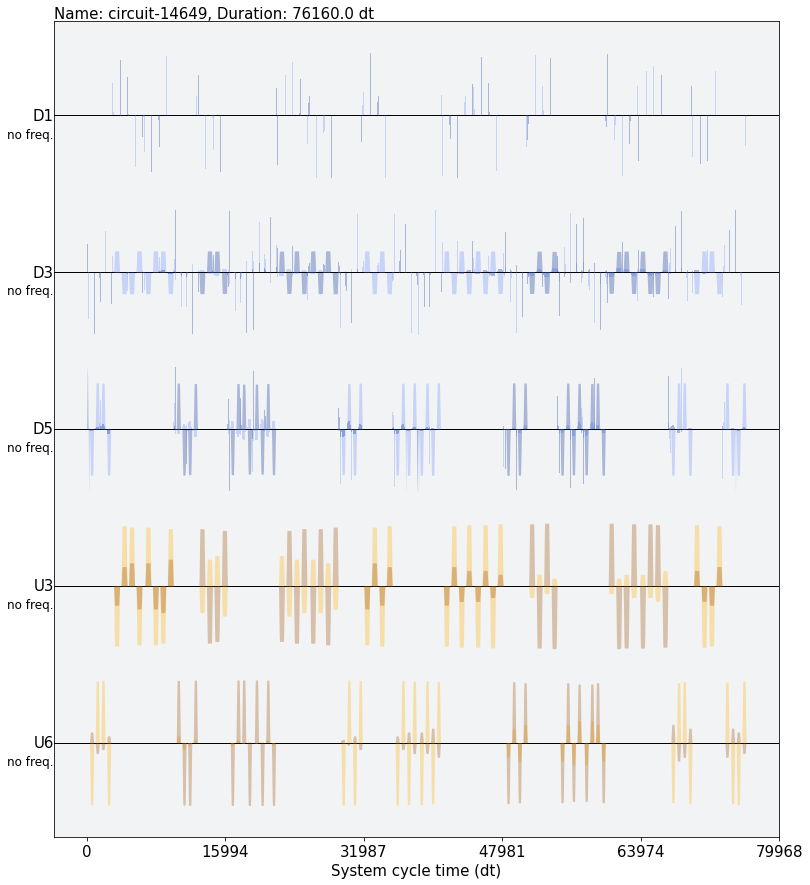

In [ ]:
display(qc_default.draw())
sched_default = schedule(transpile(qc_default, backend, optimization_level=1), backend)
display(sched_default.draw(show_waveform_info=False, show_framechange=False))

It is extremely important to point out that the duration of our custom circuit (33056 samples) is just 43% of the default circuit shown above (76160 samples). It is therefore highly likely that the results from our circuit, with it being more than twice shorter than the default one, will be significantly better.

Finally, there are 6 possible permutations of the 4 layers [0.5, 0.5, 0, 0]*$\pi$, which we have benchmaked several weeks before the deadline (i.e. before the record fidelities obtained on 04/15 - 04/16). We found that combining the two zero layers together, and placing them before, inbetween, or after the 0.5 layers yielded on average better fidelities, with little difference between the three. However, we observed a slight advantage of the [0.5,0,0,0.5] sequence over the over 5, which is why we chose it for the final solution:

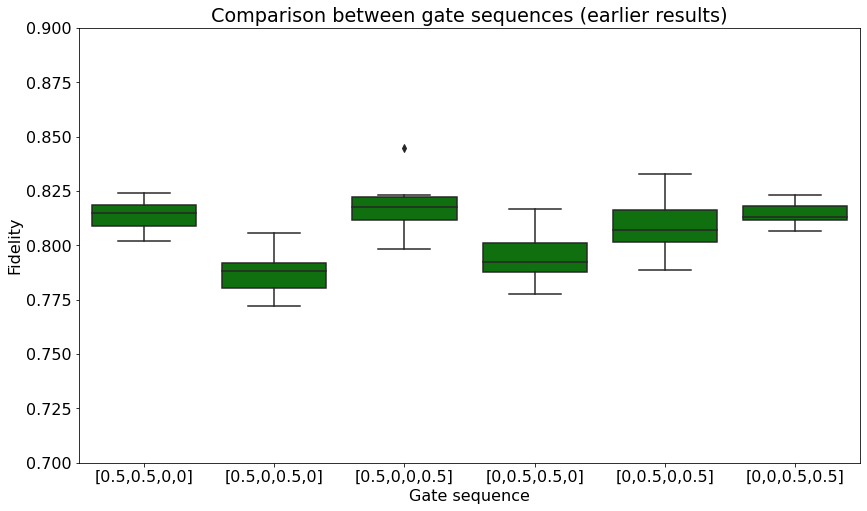

Notes:

*   The optimal sequences of $XX$, $YY$, and $ZZ$ gates in a (first-order) Trotter layer depend on the device and the physical qubits used. This is because of the assymetry in how 2q gates are experimentally implemented, related to the fact that the default $ZX(\pi/4)$ pulse in only calibrated in one direcetion between two connected qubits. As a result, for example, the gate sequence for $XX[\pi][1,3]*ZZ[\pi][3,5]$ on *ibmq_jakarata* is different from that for $XX[\pi][3,5]*ZZ[\pi][5,6]$, because the cross-resonance $ZX(\pi/4)$ pulses on that device are calibration only in the following directions: Q1 --> Q3 --> Q5 <-- Q6.

*   We have prioritized the total schedule duration over the number of 1q gates when selecting the best candidate sequences for Trotter layers. This is because ultimately, we will be adding dynamical decoupling (DD) sequences that will artificially increase the number of 1q gates in attempt to fight dephasing on idling qubits.



##3.4   Dynamical decoupling at pulse level (expand for details)

We have developed a custom function ``add_DD()`` that identifies time intervals when qubits are idle and inserts 1q identity blocks $X*Y*X*Y$, so-called XY4 dynamical decoupling (DD). Let us illustrate how it works. Assume we have a pulse schedule that we would like to insert DD identities in:

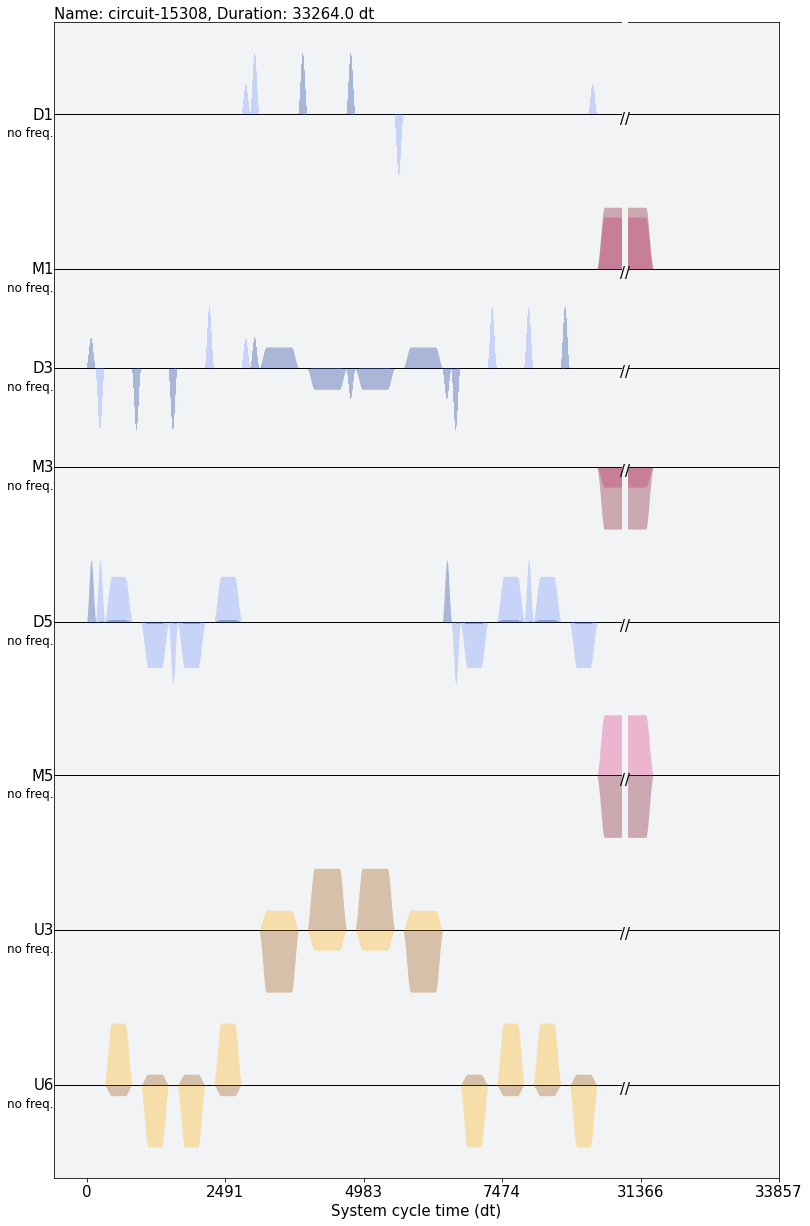

In [ ]:
qc_test = QuantumCircuit(7, 3)

qc_test.x(3,5)
qc_test.ry(np.pi/2,[3,5])
qc_test.cnot(3,5)
qc_test.rz(np.pi, 5)
qc_test.cnot(3,5)
qc_test.ry(-np.pi/2,[3,5])

qc_test.rx(np.pi/2,[1,3])
qc_test.cnot(1,3)
qc_test.rz(np.pi, 3)
qc_test.cnot(1,3)
qc_test.rx(-np.pi/2,[1,3])

qc_test.x(3,5)
qc_test.cnot(3,5)
qc_test.rz(np.pi, 5)
qc_test.cnot(3,5)

qc_test.measure((1,3,5), (0,1,2))
sched_test = schedule(transpile(qc_test, backend, optimization_level=1), backend)
sched_test.draw(show_waveform_info=False, show_framechange=False)

Let us now insert DD sequences on Q1 and Q5:

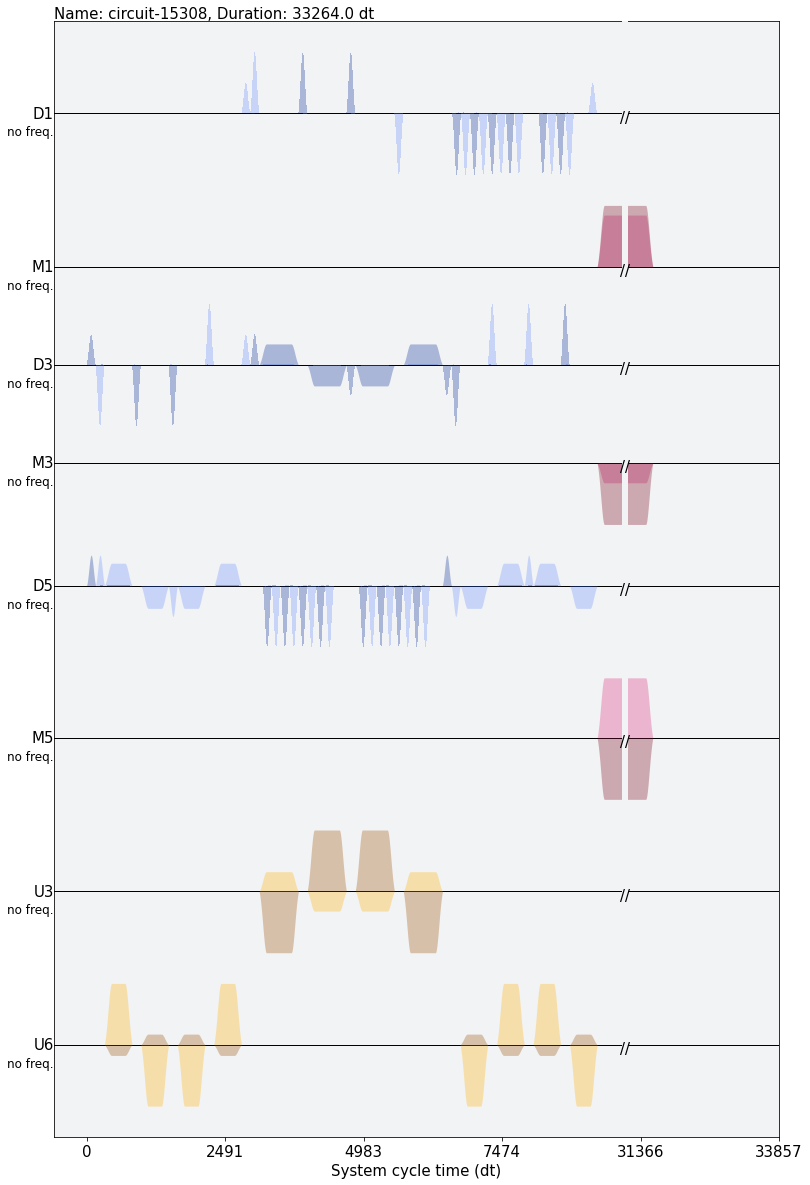

In [ ]:
# list of lists of qubits to add DD sequences to
qq_DD = [1, 5]

inst_map = extract_X_pulse_parameters_for_qubits(backend_config, inst_map)
sched_test_DD = add_DD(sched_test, qq_DD, backend_config, inst_map)
sched_test_DD.draw(show_waveform_info=False, show_framechange=False)

DD sequences have been added on idling intervals on the corresponding drive channels. We use the default calubrated $X$ pulses on each qubit and $R_z$ gates to construct the $XY4$ sequences and insert their multiples into neccessary intervals in the schedule. Note that our ``add_DD()`` function is smart enough to recognize that DD identities should not be inserted:

*   before the first operation on the qubit
*   during measurements
*   during pulses on control channels associated with the qubit



##3.5   Measurement error mitigation (expand for details)

Finally, we used the default Qiskit measurement error mitigation module ``qiskit.ignis.mitigation`` by prepending the 8 measurement calibration circuits for the 3 involved qubits to the set of schedules performing state tomography experiments (within the same job).

# 4 Solution

##Baseline: Trotterization scheme using default $XX$, $YY$, and $ZZ$ gates (no need to run)

We first benchmark the default 4-step Trotterization circuit using the same gate sequence in each Trotterization layer as we do in our solution: *xZXyYz*

In [ ]:
# Parameterize variable t to be evaluated at t=pi later
t1 = Parameter('t1')
t2 = Parameter('t2')

In [ ]:
# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX1')

XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t1, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX1 = XX_qc.to_instruction()

# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX2')

XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t2, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX2 = XX_qc.to_instruction()

In [ ]:
# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY1')

YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t1, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY1 = YY_qc.to_instruction()

# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY2')

YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t2, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY2 = YY_qc.to_instruction()

In [ ]:
# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ1')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t1, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ1 = ZZ_qc.to_instruction()

# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ2')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t2, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ2 = ZZ_qc.to_instruction()

In [ ]:
target_time = np.pi
###
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc1 = QuantumCircuit(Trot_qr, name='Trot1')

# xZXyYz
Trot_qc1.append(XX1, [Trot_qr[0], Trot_qr[1]])
Trot_qc1.append(ZZ1, [Trot_qr[1], Trot_qr[2]])
Trot_qc1.append(XX1, [Trot_qr[1], Trot_qr[2]])
Trot_qc1.append(YY1, [Trot_qr[0], Trot_qr[1]])
Trot_qc1.append(YY1, [Trot_qr[1], Trot_qr[2]])
Trot_qc1.append(ZZ1, [Trot_qr[0], Trot_qr[1]])

Trot_gate1 = Trot_qc1.to_instruction()

###
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc2 = QuantumCircuit(Trot_qr, name='Trot2')

# xZXyYz
Trot_qc2.append(XX2, [Trot_qr[0], Trot_qr[1]])
Trot_qc2.append(ZZ2, [Trot_qr[1], Trot_qr[2]])
Trot_qc2.append(XX2, [Trot_qr[1], Trot_qr[2]])
Trot_qc2.append(YY2, [Trot_qr[0], Trot_qr[1]])
Trot_qc2.append(YY2, [Trot_qr[1], Trot_qr[2]])
Trot_qc2.append(ZZ2, [Trot_qr[0], Trot_qr[1]])

Trot_gate2 = Trot_qc2.to_instruction()

In [ ]:
shots = 8192
reps = 8

qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

qc.append(Trot_gate1, [qr[1], qr[3], qr[5]])
qc.append(Trot_gate2, [qr[1], qr[3], qr[5]])
qc.append(Trot_gate2, [qr[1], qr[3], qr[5]])
qc.append(Trot_gate1, [qr[1], qr[3], qr[5]])

We added a small duration on the zero-time Trotterization layers in order to prevent the transpiler from removing those layers, while still optimizing other 1q gates in the circuit.

In [ ]:
#qc = qc.bind_parameters({t1: 2*(target_time/2)*(1/2), t2: 0})
qc = qc.bind_parameters({t1: 2*(target_time/2)*(0.4999), t2: 0.0001})

st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
display(st_qcs[-1].draw())

»
q2770_0: ─────────────────────────────────────────────────────────────────────»
              ┌──────────────────────────┐┌────────────────┐┌────────────────┐»
q2770_1: ─────┤0                         ├┤0               ├┤0               ├»
              │                          ││                ││                │»
q2770_2: ─────┤                          ├┤                ├┤                ├»
         ┌───┐│                          ││                ││                │»
q2770_3: ┤ X ├┤1 Trot1(1.57048216752954) ├┤1 Trot2(0.0001) ├┤1 Trot2(0.0001) ├»
         └───┘│                          ││                ││                │»
q2770_4: ─────┤                          ├┤                ├┤                ├»
         ┌───┐│                          ││                ││                │»
q2770_5: ┤ X ├┤2                         ├┤2               ├┤2               ├»
         └───┘└──────────────────────────┘└────────────────┘└────────────────┘»
q2770_6: ─────────────────────────────────────────────────────────────────────»
                                                                              »
  c45: 3/═════════════════════════════════════════════════════════════════════»
                                                                              »
«                                      ░          
«q2770_0: ─────────────────────────────░──────────
«         ┌──────────────────────────┐ ░ ┌─┐      
«q2770_1: ┤0                         ├─░─┤M├──────
«         │                          │ ░ └╥┘      
«q2770_2: ┤                          ├─░──╫───────
«         │                          │ ░  ║ ┌─┐   
«q2770_3: ┤1 Trot1(1.57048216752954) ├─░──╫─┤M├───
«         │                          │ ░  ║ └╥┘   
«q2770_4: ┤                          ├─░──╫──╫────
«         │                          │ ░  ║  ║ ┌─┐
«q2770_5: ┤2                         ├─░──╫──╫─┤M├
«         └──────────────────────────┘ ░  ║  ║ └╥┘
«q2770_6: ─────────────────────────────░──╫──╫──╫─
«                                      ░  ║  ║  ║ 
«  c45: 3/════════════════════════════════╩══╩══╩═
«                                         0  1  2

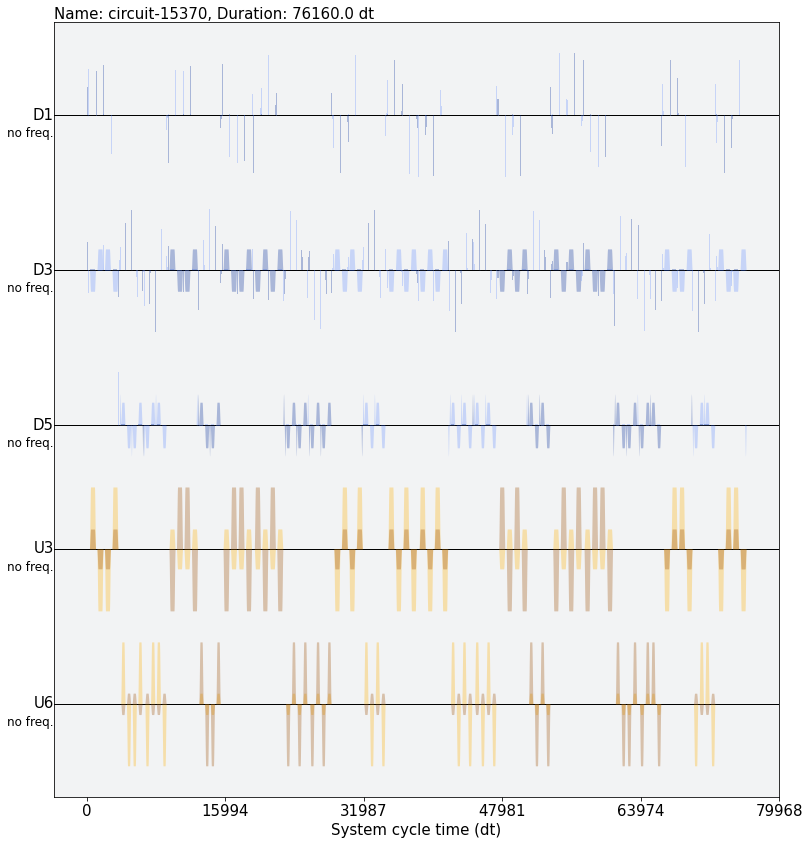

In [ ]:
schedule(transpile(qc, backend, optimization_level=1), backend).draw(show_waveform_info=False, show_framechange=False)

We intentionally did not add DD sequences or perform measurement error mitigation here. Out goal was to see the fidelity of the default circuit corresponding to our solution.

In [ ]:
jobs = []
job_ids = ['625b4208e1f2453029eb6cb2', '625b4214a7e96683bcdee839', '625b4221e3b67f037e3abd46', '625b422e7368944815c8bcb5', '625b423b35e1eccce5253709', '625b424835e1ec81cd25370a', '625b42548e4b234464d309f6', '625b42613bbc9f4750735c1f'] # Default
for i in range(reps):
    # retrieve job
    job_id = job_ids[i]
    job = backend.retrieve_job(job_id)
    # execute
    #job = execute(st_qcs, backend, shots=shots)
    #job_id = job.job_id() 
    job_ids.append(job_id)
    jobs.append(job)
print(f"job_ids = {job_ids} # Default")

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    print(f"fidelity = {round(fid, 3)}")
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

job_ids = ['625b4208e1f2453029eb6cb2', '625b4214a7e96683bcdee839', '625b4221e3b67f037e3abd46', '625b422e7368944815c8bcb5', '625b423b35e1eccce5253709', '625b424835e1ec81cd25370a', '625b42548e4b234464d309f6', '625b42613bbc9f4750735c1f', '625b4208e1f2453029eb6cb2', '625b4214a7e96683bcdee839', '625b4221e3b67f037e3abd46', '625b422e7368944815c8bcb5', '625b423b35e1eccce5253709', '625b424835e1ec81cd25370a', '625b42548e4b234464d309f6', '625b42613bbc9f4750735c1f'] # Default
fidelity = 0.322
fidelity = 0.307
fidelity = 0.292
fidelity = 0.307
fidelity = 0.312
fidelity = 0.31
fidelity = 0.312
fidelity = 0.304
state tomography fidelity = 0.3082 ± 0.0081


state tomography fidelity = 0.3082 ± 0.0081

The default circuit gave 0.3 fidelity, averaged over 8 jobs (8192 shots each) (which is matches the minimum necessary, as per the challenge rules).

## Our solution

In this solution we combine all techniques explained in Section 3:

*   Custom pulse decomposition of $XX(\theta)$, $YY(\theta)$, $ZZ(\theta)$ gates, allowing to reduce the duration of these gates by up to 50%

*   We employed 4-step Trotterization scheme with unequal evolution intervals. We used the scheme that evolves the initial state in 4 steps: $[0.5,0,0,0.5]*\pi$. We designed the custom $XX(0)$, $YY(0)$, $ZZ(0)$ gates such that they still play all 1q pulses without cancelling them out, to make sure that our solution satisfies the 4-step requirement of the competition. AJ Rasmusson also confirmed that this is within the competion rules. Note that modifying the scheme to something like $[0.499, 0.01, 0.01, 0.499]*\pi$ would not alter or break our approach, (it will reduce the fidelity by up to 0.1). This would add negligibly small-amplitude CR pulses for very short duration (64 or 128 samples). Considering this, we proceeded with benchmerking the ideal $[0.5,0,0,0.5]*\pi$ Trotterizations scheme for best possible result. To reiterate, no additional 1q gate cancellations occured due to having these two zero-time Trotterization steps.

*   We have found a small set of optimal sequences of $XX$, $YY$, and $ZZ$ gates within the Trotterization layer by a combination of rational design (narrowing down from 720 to just 8 options by minimizing the total duration of the circuit and selecting those sequenced that would maximize the advantage from adding dynamical decoupling) and empirical studies (experiments), to decing on the final sequance 'xZXyYz' for all layers. We were able to achieve a circuit with duration just 43% of the default one, significantly reducing accumulation of errors.

*   Similarly, the potiions of the zero-time layers (6 options total) were determined based on experiments, resulting in $[0.5,0,0,0.5]*\pi$ which gave the highest and most consistent results.

*   We employed dynamical decoupling to mitigate decoherence on idling qubits. We discovered that applying DD only to Q1 gave the best results. There are no idling intervals on Q3, and $XY4$ identity sequences on Q5 produced more errors than corrected.

*   Each experiment was processed using the standard Qiskit measurement error mitigation module ``qiskit.ignis.mitigation``.

*   We have considered taking advantage of the unused qubits adjacent to Q1 and Q5 on *ibmq_jakarta*. However, they were insufficient to implement a bit-flip error correction code with high fidelity. An alternative strategy could be as follows. By adding CNOT gates controlled on Q1 and or Q5, it could be possible to transfer the states of these qubits (|0> or |1>) to their neighbors. E.g., let us assume we added CNOT[1,0] after the Trotterization schedule. If Q1 is in the |0> state, then Q0 will remain in the |0> state, however if Q1 ends up in |1>, the state of Q0 would also flip to |1>.
By then measuring this neighbor qubit Q0 instead of the original Q1 it may be possible to get a higher fidelity, assuming that readout errors of Q0 are significantly lower than of Q1 to justify the addition of the CNOT gate. However, we ultimately chose not to implement this strategy in our solution because we did not find it to be stable enough. Readout errors of qubit vary over time, and in order to ensure that this approach improves always the fidelity, one would need to additional verification/calibrations that would reduce our solution's universality and generalizability to other Hamiltonians and/or final states after the evolution. In contrast, we found that performing dynamical decoupling only on Q1 always improves the fidelity of our solution. The same is true to the particular ordering of the $XX$, $YY$, and $ZZ$ gates in the Trotterization layer (denoted as 'xZXyYz'), which has consistently outperformed most other gate sequences over the course of several weeks.
 


**The cell below executes our solution:**

In [ ]:
qq = [1,3,5]

shots = 8192
reps = 8

# Optimal order of 2q gates in each Trotterization layer
seq = 'xZXyYz'

# List of individual durations of each Trotter step, for total evolution of t = pi.
theta_list = np.array([0.5, 0, 0, 0.5])*2*np.pi

# A small modification that makes sure that the last pulse on Q1 is not delayed until the end of the circuit,
# and instead is shifted to the earliert possible position
shifted = True

# For dynamical decoupling
inst_map = extract_X_pulse_parameters_for_qubits(backend_config, inst_map)

# Only adding dynamical decoupling sequences on Q1 (gives best results)
qq_DD = [qq[0]]

# Generate the circuit for our solution
qc_T = qc_Trot(seq, theta_list, qq, shifted=shifted)
circ_sched = schedule(qc_T, backend)

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc_T, qq)

# Insert DD sequences into the pulse schedule of each state tomography circuit
st_qcs_DD_schedules = []
for i, circ in enumerate(st_qcs):   
    sched = schedule(transpile(circ, backend), backend)
    st_qcs_DD_schedules.append(sched)
st_qcs_DD = [add_DD(sched, qq_DD, backend_config, inst_map) for sched in st_qcs_DD_schedules]

exp_circs, meas_labels = setup_mitigation(backend, st_qcs_DD, qubits=sorted(qq))

# exp_circs here is a mix of mit circuits and DD schedules
exp_scheds = schedule(transpile(exp_circs[:len(meas_labels)], backend, optimization_level=1), backend) + st_qcs_DD
print(f"\n# {backend.name()}{qq}: [{seq}] DD{qq_DD} theta_list=[{round(theta_list[0]/2/np.pi, 2)}, {round(theta_list[1]/2/np.pi, 2)}, {round(theta_list[2]/2/np.pi, 2)}, {round(theta_list[3]/2/np.pi, 2)}]*pi ")

# Execute
job_ids = []
for _ in range(reps):
    qobj = assemble(exp_scheds,
                    backend=backend,
                    rep_delay=50e-6,
                    shots=shots)
    job = backend.run(qobj, job_share_level='global')  
    job_id = job.job_id() 
    job_ids.append(job_id)
print(f"job_ids = {job_ids} # [{seq}] DD{qq_DD} theta_list=[{round(theta_list[0]/2/np.pi, 2)}, {round(theta_list[1]/2/np.pi, 2)}, {round(theta_list[2]/2/np.pi, 2)}, {round(theta_list[3]/2/np.pi, 2)}]*pi ")

# Retrieve results
jobs = [] 
for job_id in job_ids:
  job = backend.retrieve_job(job_id)
  jobs.append(job)

# Compute tomography fidelities with (mit) and without (raw) measurement error mitigation
fids_raw = []
fids_mit = []
for job in jobs:
    result_raw = get_result(job, mem_slots=[0,1,2], meas_labels=meas_labels, no_mit=True)
    result_mit = get_result(job, mem_slots=[0,1,2], meas_labels=meas_labels)
    fid_raw = state_tomo(result_raw, st_qcs)
    fid_mit = state_tomo(result_mit, st_qcs)
    fids_raw.append(fid_raw)
    fids_mit.append(fid_mit)
    print(f"fidelity = {round(fid_mit, 3)} (raw {round(fid_raw, 3)})")
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f} (raw {:.4f} \u00B1 {:.4f})'.format(np.mean(fids_mit), np.std(fids_mit), np.mean(fids_raw), np.std(fids_raw)))

Our best results were obtained 4 hours before the deadline of the submission (the last seven jobs in the list below, which were executed consequtively - no cherry-picking!). For completeness, we added more jobs/examples from the day before, 12 jobs total:

In [ ]:
job_ids = ['625b32cf9e31158609838adf', '625b32dde1f245648aeb6c77', '625b32eba7e966bf85dee7f6', '625b32f8e1f2453b01eb6c7a', '625b330735e1ec66a02536d4'] + ['625b54e035e1ec719b25372f', '625b54e9e3b67ffe193abd6c', '625b54f00d8f191bbfac1a99', '625b54f5e1f2455522eb6cd6', '625b54fb9e31153613838b40', '625b55017368947e69c8bcd9', '625b55073bbc9f2f99735c43']

Let us retrieve these results (please run using the original credentials/IBMQ Provider):

In [ ]:
jobs = [] 

meas_labels = ['000', '001', '010', '011', '100', '101', '110', '111']

for job_id in job_ids:
  job = backend.retrieve_job(job_id)
  jobs.append(job)

# Compute tomography fidelities for each repetition
fids_raw = []
fids_mit = []
for job in jobs:
    result_raw = get_result(job, mem_slots=[0,1,2], meas_labels=meas_labels, no_mit=True)
    result_mit = get_result(job, mem_slots=[0,1,2], meas_labels=meas_labels)
    fid_raw = state_tomo(result_raw, st_qcs)
    fid_mit = state_tomo(result_mit, st_qcs)
    fids_raw.append(fid_raw)
    fids_mit.append(fid_mit)
    print(f"fidelity = {round(fid_mit, 3)} (raw {round(fid_raw, 3)})")
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f} (raw {:.4f} \u00B1 {:.4f})'.format(np.mean(fids_mit), np.std(fids_mit), np.mean(fids_raw), np.std(fids_raw)))

We have achieved state tomography fidelity of **0.8666 ± 0.0100**, averaged over 12 jobs (8192 shots each) from 2 different days.

# 5 Conclusions and future work

Conclusions:

*   We have developed and adapted a range of techniques using Qiskit Pulse and other Qiskit modules to achieve the highest state tomography fidelity of evolving the |110> state in 4 Trotterization steps. The best result we were able to achieve on *ibmq_jakarta[1,3,5]* was the fidelity of **0.8666 ± 0.0100**, averaged over 12 jobs (8192 shots each).

*   We have created a powerful set of IBMQ-device-agnostic pulse-level optimization to $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gates that allow to reduce the duration of these gate by up to 50% without any additional calibration overhead or reduction in fidelity.

*   Our approach to optimizing the 4-step Trotterization scheme is universal and does not rely on the for of the Hamiltonian, the state evolved, or the duration of the evolution. The same steps can be followed for similar problems.


Our work can be advanced by considering the following improvements:

*   Instead of using the first-order Trotterization scheme with 6 pulse-optimized 2q gates, we will attempt to find an even shorter way to compose the entire Trotterization step out of 1q and $XZ(\pm\theta)$ rescaled gates. The complexity of the search of such 3q operator decompositions was not possible by the deadline of this chellenge. However, we plan to implement it, benchmark, and publish as an articl and a blog post.

*   Robust error correction using ancilla qubits.



#6 Attachments

Please find attached with this submission:


*   Figures 1, 2 as png files


# 7 Qiskit Version Information

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table